The model consists of a transformer embedding + encoder + decoder.

Inference is performed by starting with an SOS token and predicting one character at a time using the previous prediction.

Inference requires the encoder to encode the input frames and subsequently use that encoding to predict the 1st character by inputting the encoding and SOS (Start of Sentence) token. Next, the encoding, SOS token and 1st predicted token are used to predict the 2nd character. Inference thus requires 1 call to the encoder and multiple calls to the encoder. On average a phrase is 18 characters long, requiring 18+1(SOS token) calls to the decoder.

Some inspiration is taken from the [1st place solution - training](https://www.kaggle.com/code/hoyso48/1st-place-solution-training) from the last [Google - Isolated Sign Language Recognition
](https://www.kaggle.com/competitions/asl-signs) competition.

Special thanks for all of these guys, Many many thanks to them: 

https://www.kaggle.com/competitions/asl-fingerspelling/discussion/434364

[1st place solution] Improved Squeezeformer + TransformerDecoder + Clever augmentations: https://www.kaggle.com/competitions/asl-fingerspelling/discussion/434485

[5th place solution] Vanilla Transformer, Data2vec Pretraining, CutMix, and KD: https://www.kaggle.com/competitions/asl-fingerspelling/discussion/434415

https://www.kaggle.com/code/gusthema/asl-fingerspelling-recognition-w-tensorflow

This man helps me alot: https://www.kaggle.com/competitions/asl-fingerspelling/discussion/411060

The processing is as follows:

1) Select dominant hand based on most number of non empty hand frames

2) Filter out all frames with missing dominant hand coordinates

3) Resize video to 256 frames

4) Excluding samples with low frames per character ratio

5) Added phrase type

You Can Find the data and the competition here: https://www.kaggle.com/competitions/asl-fingerspelling/overview

In [1]:
#For MLOPS
#You can find more about it here, special thanks for: https://medium.com/@darragh.hanley_94135/mastering-mlops-with-neptune-ai-84e635d36bf2
!pip install neptune

  Obtaining dependency information for neptune from https://files.pythonhosted.org/packages/29/94/f39ba36f693bc53486bdd7094ad801847fabeed29e834cb392e11c2b9b7b/neptune-1.8.6-py3-none-any.whl.metadata
  Obtaining dependency information for boto3>=1.28.0 from https://files.pythonhosted.org/packages/1c/4f/9c1e00f7a3a4ea09c3f24f64f796e627bb5d002d96151087b3ec79e957c7/boto3-1.34.11-py3-none-any.whl.metadata
  Obtaining dependency information for botocore<1.35.0,>=1.34.11 from https://files.pythonhosted.org/packages/c7/dd/dbe47b84a88a31d3e4c0a4b3c50c03b8475215807d6d3f416c345c850f4b/botocore-1.34.11-py3-none-any.whl.metadata
  Obtaining dependency information for s3transfer<0.11.0,>=0.10.0 from https://files.pythonhosted.org/packages/12/bb/7e7912e18cd558e7880d9b58ffc57300b2c28ffba9882b3a54ba5ce3ebc4/s3transfer-0.10.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [136]:
# Uninstall the previous installed nltk library
!pip install -U nltk

# This upgraded nltkto version 3.5 in which meteor_score is there.
!pip install nltk==3.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.9 MB/s eta 0:00:0000:010:01
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434678 sha256=1165a82c5c3ab07d3fb6d806ea69e817d480e8fae9ac540b8cdbf8e55f440b0f
  Stored in directory: /root/.cache/pip/wheels/35/ab/82/f9667f6f884d272670a15382599a9c753a1dfdc83f7412e37d
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.

In [139]:
import sacrebleu
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from nltk.translate.meteor_score import meteor_score

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from pathlib import Path
from leven import levenshtein

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import time
import json
import re

print(f'Tensorflow Version {tf.__version__}')
print(f'Python Version: {sys.version}')
# TQDM Progress Bar With Pandas Apply Function
tqdm.pandas()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Tensorflow Version 2.13.0
Python Version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]


# Character 2 Ordinal Encoding

You have first get the data from the competition, you can find it here: https://www.kaggle.com/competitions/asl-fingerspelling/data

In [3]:
# Read Character to Ordinal Encoding Mapping
with open('/kaggle/input/asl-fingerspelling/character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)
    
# Ordinal to Character Mapping
ORD2CHAR = {j:i for i,j in CHAR2ORD.items()}
    
# Character to Ordinal Encoding Mapping   
display(pd.Series(CHAR2ORD).to_frame('Ordinal Encoding'))

,Ordinal Encoding
,0
!,1
#,2
$,3
%,4
&,5
',6
(,7
),8
*,9


# Global Config

In [4]:
# If Notebook Is Run By Committing or In Interactive Mode For Development
IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
# Verbose Setting during training
VERBOSE = 1 if IS_INTERACTIVE else 2
# Describe Statistics Percentiles
PERCENTILES = [0.01, 0.10, 0.05, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 0.999]
# Global Random Seed
SEED = 42
# Number of Frames to resize recording to
N_TARGET_FRAMES = 128
# Global debug flag, takes subset of train
DEBUG = False
# Fast Processing
FAST= False
# Number of Unique Characters To Predict + Pad Token + SOS Token + EOS Token
N_UNIQUE_CHARACTERS0 = len(CHAR2ORD)
N_UNIQUE_CHARACTERS = len(CHAR2ORD) + 1 + 1 + 1
PAD_TOKEN = len(CHAR2ORD) # Padding
SOS_TOKEN = len(CHAR2ORD) + 1 # Start Of Sentence
EOS_TOKEN = len(CHAR2ORD) + 2 # End Of Sentence
# Whether to use 10% of data for validation
USE_VAL = True
# Batch Size
BATCH_SIZE = 64
# Number of Epochs to Train for
N_EPOCHS = 100
# Number of Warmup Epochs in Learning Rate Scheduler
N_WARMUP_EPOCHS = 10
# Maximum Learning Rate
LR_MAX = 1e-3
# Weight Decay Ratio as Ratio of Learning Rate
WD_RATIO = 0.05
# Length of Phrase + EOS Token
MAX_PHRASE_LENGTH = 31 + 1
# Whether to Train The model
TRAIN_MODEL = True
# Whether to Load Pretrained Weights
LOAD_WEIGHTS = False
# Learning Rate Warmup Method [log,exp]
WARMUP_METHOD = 'exp'

# Neptune project, our MLOps stack.

In [5]:
# Get neptune Framework to log (loss, val_loss, and alot more) for each run.
import neptune

#Connect your Neptune project with your code
run = neptune.init_run(
    #Your Project Name in Neptune.ai
    project="ASL-/ASL",
    #Your API_TOKEN, this will help you: https://medium.com/@darragh.hanley_94135/mastering-mlops-with-neptune-ai-84e635d36bf2
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1NWFkNWMwNi00MTMzLTRiZGMtYjIwZi1jNGI0ZTU1MDVjNDYifQ==",
)  

/tmp/ipykernel_42/1204933424.py:5: NeptuneWarning: The following monitoring options are disabled by default in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', and 'capture_hardware_metrics'. To enable them, set each parameter to 'True' when initializing the run. The monitoring will continue until you call run.stop() or the kernel stops. Also note: Your source files can only be tracked if you pass the path(s) to the 'source_code' argument. For help, see the Neptune docs: https://docs.neptune.ai/logging/source_code/
  run = neptune.init_run(


https://app.neptune.ai/ASL-/ASL/e/ASL-33


# Plot Config

In [6]:
# MatplotLib Global Settings
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 24

# EDA and PreProcessing

## Utils

In [7]:
# Prints Shape and Dtype For List Of Variables
def print_shape_dtype(l, names):
    for e, n in zip(l, names):
        print(f'{n} shape: {e.shape}, dtype: {e.dtype}')

## Train

In [8]:
# Read Train DataFrame
if DEBUG:
    train = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv').head(5000)
else:
    train = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')
    
# Set Train Indexed By sqeuence_id
train_sequence_id = train.set_index('sequence_id')

# Number Of Train Samples
N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

display(train.info())
display(train.head())

N_SAMPLES: 67208
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67208 entries, 0 to 67207
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            67208 non-null  object
 1   file_id         67208 non-null  int64 
 2   sequence_id     67208 non-null  int64 
 3   participant_id  67208 non-null  int64 
 4   phrase          67208 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.6+ MB


None

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road


## Phrase Type

In [9]:
"""
Attempt to retrieve phrase type
Could be used for pretraining or type specific inference
 *) Phone Number\
 *) URL
 *3) Addres
"""
def get_phrase_type(phrase):
    # Phone Number
    if re.match(r'^[\d+-]+$', phrase):
        return 'phone_number'
    # url
    elif any([substr in phrase for substr in ['www', '.', '/']]) and ' ' not in phrase:
        return 'url'
    # Address
    else:
        return 'address'
    
train['phrase_type'] = train['phrase'].apply(get_phrase_type)

## File Path

In [10]:
# Get complete file path to file
def get_file_path(path):
    return f'/kaggle/input/asl-fingerspelling/{path}'

train['file_path'] = train['path'].apply(get_file_path)

## Example File Paths

In [11]:
# Unique Parquet Files
INFERENCE_FILE_PATHS = pd.Series(
        glob.glob('/kaggle/input/aslfr-preprocessing-dataset/train_landmark_subsets/*')
    )

print(f'Found {len(INFERENCE_FILE_PATHS)} Inference Pickle Files')

Found 10 Inference Pickle Files


## Phrase Processing

In [12]:
# Split Phrase To Char Tuple
train['phrase_char'] = train['phrase'].apply(tuple)
# Character Length of Phrase
train['phrase_char_len'] = train['phrase_char'].apply(len)

# Maximum Input Length
MAX_PHRASE_LENGTH = train['phrase_char_len'].max()
print(f'MAX_PHRASE_LENGTH: {MAX_PHRASE_LENGTH}')

# Train DataFrame indexed by sequence_id to convenientlyy lookup recording data
train_sequence_id = train.set_index('sequence_id')

MAX_PHRASE_LENGTH: 31


In [13]:
# Phrase Character Length Statistics
display(train['phrase_char_len'].describe(percentiles=PERCENTILES).to_frame().round(1))

,phrase_char_len
count,67208.0
mean,17.8
std,5.7
min,1.0
1%,8.0
5%,11.0
10%,12.0
25%,12.0
50%,17.0
75%,22.0


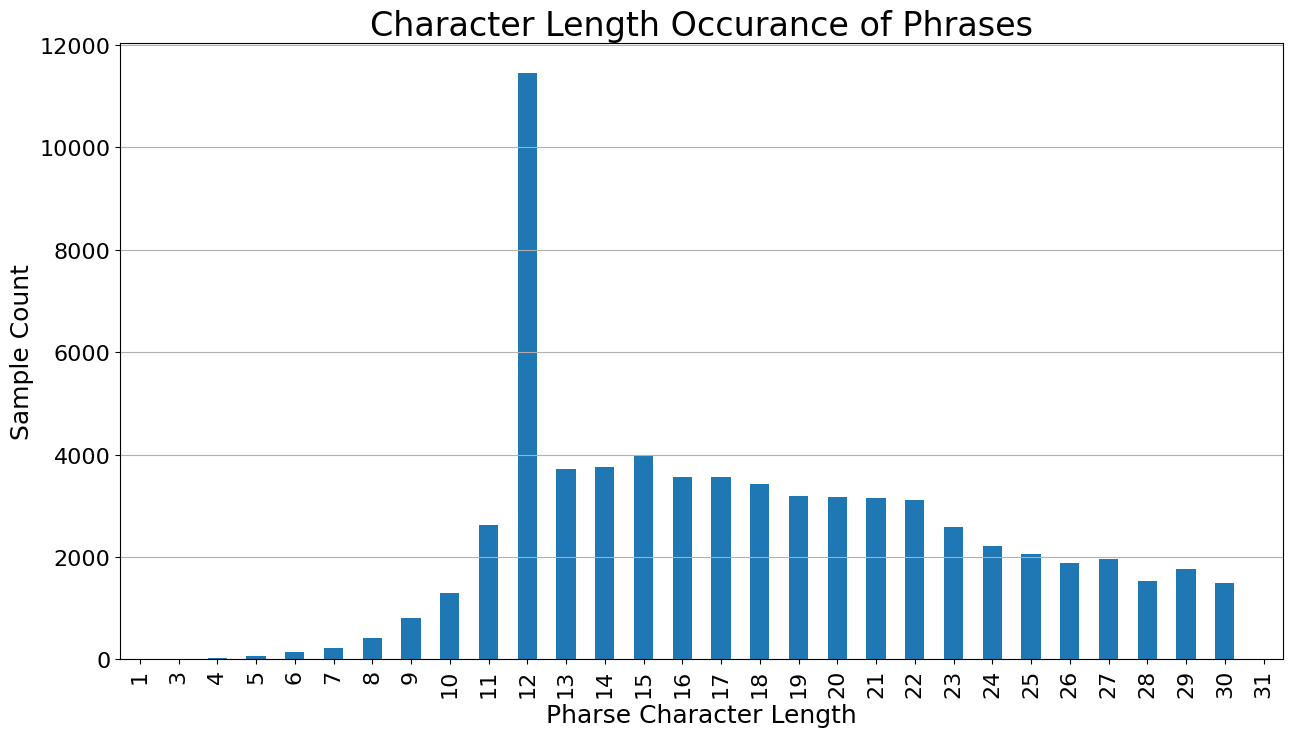

In [14]:
# Character Count Occurance
plt.figure(figsize=(15,8))
plt.title('Character Length Occurance of Phrases')
train['phrase_char_len'].value_counts().sort_index().plot(kind='bar')
plt.xlim(-0.50, train['phrase_char_len'].max() - 1.50)
plt.xlabel('Pharse Character Length')
plt.ylabel('Sample Count')
plt.grid(axis='y')
plt.show()

## Find Unique Character

In [15]:
# Use Set to keep track of unique characters in phrases
UNIQUE_CHARACTERS = set()

for phrase in tqdm(train['phrase_char']):
    for c in phrase:
        UNIQUE_CHARACTERS.add(c)
        
# Sorted Unique Character
UNIQUE_CHARACTERS = np.array(sorted(UNIQUE_CHARACTERS))
# Number of Unique Characters
print(f'N_UNIQUE_CHARACTERS: {N_UNIQUE_CHARACTERS}')

  0%|          | 0/67208 [00:00<?, ?it/s]

N_UNIQUE_CHARACTERS: 62


## Example Parquet File

In [16]:
# Read First Parquet File
example_parquet_df = pd.read_parquet(train['file_path'][0])

# Each parquet file contains 1000 recordings
print(f'# Unique Recording: {example_parquet_df.index.nunique()}')
# Display DataFrame layout
display(example_parquet_df.head())

# Unique Recording: 1000


,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1816796431,0,0.710588,0.699951,0.705657,0.691768,0.699669,0.701980,0.709724,0.610405,0.712660,...,-0.245855,-0.269148,-0.129743,-0.251501,-0.278687,-0.266530,-0.152852,-0.257519,-0.275822,-0.266876
1816796431,1,0.709525,0.697582,0.703713,0.691016,0.697576,0.700467,0.709796,0.616540,0.713729,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,2,0.711059,0.700858,0.706272,0.693285,0.700825,0.703319,0.711549,0.615606,0.715143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816796431,3,0.712799,0.702518,0.707840,0.694899,0.702445,0.704794,0.712483,0.625044,0.715677,...,-0.370770,-0.408097,-0.185217,-0.325494,-0.343373,-0.328294,-0.203126,-0.315719,-0.326104,-0.314282
1816796431,4,0.712349,0.705451,0.709918,0.696006,0.705180,0.706928,0.712685,0.614356,0.714875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Video Statistics

In [17]:
# Number of parquet chunks to analyse
N = 5 if IS_INTERACTIVE else 25
# Number of Unique Frames in Recording
N_UNIQUE_FRAMES = []

UNIQUE_FILE_PATHS = pd.Series(train['file_path'].unique())

for idx, file_path in enumerate(tqdm(UNIQUE_FILE_PATHS.sample(N, random_state=SEED))):
    df = pd.read_parquet(file_path)
    for group, group_df in df.groupby('sequence_id'):
        N_UNIQUE_FRAMES.append(group_df['frame'].nunique())

# Convert to Numpy Array
N_UNIQUE_FRAMES = np.array(N_UNIQUE_FRAMES)

  0%|          | 0/5 [00:00<?, ?it/s]

,Value
count,4996
mean,160
std,83
min,1
1%,6
5%,36
10%,68
25%,104
50%,150
75%,206


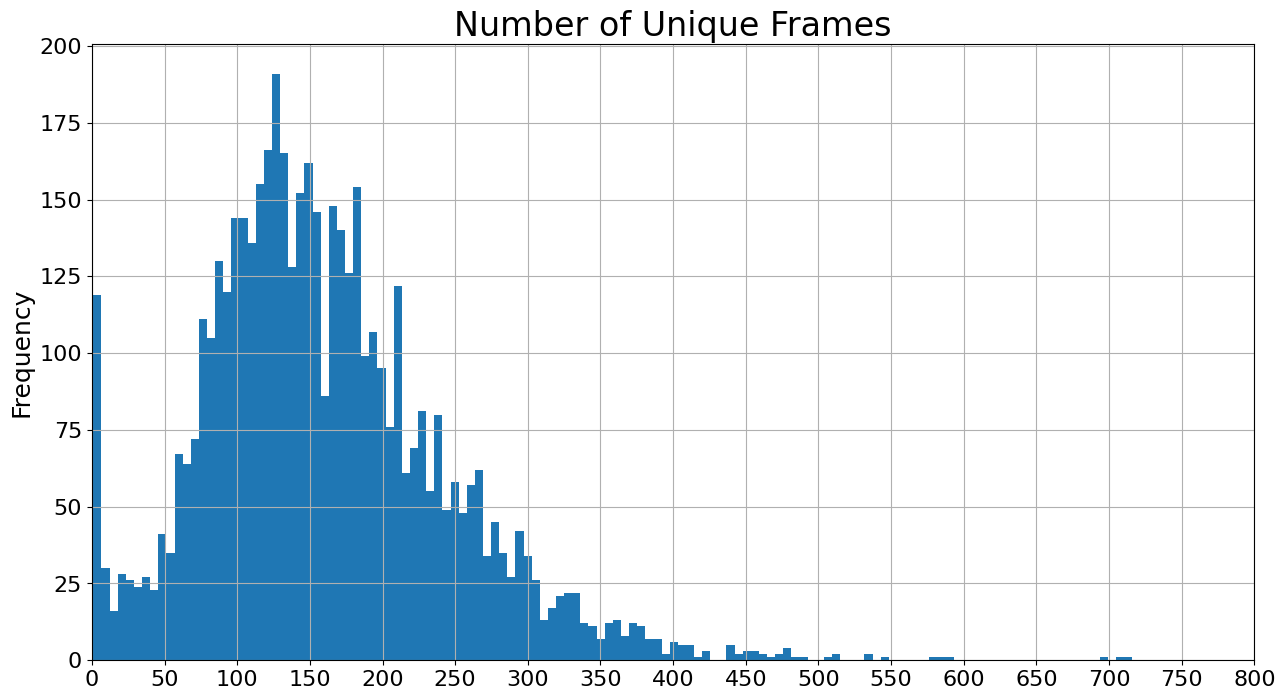

In [18]:
# Number of unique frames in each video
display(pd.Series(N_UNIQUE_FRAMES).describe(percentiles=PERCENTILES).to_frame('Value').astype(int))

plt.figure(figsize=(15,8))
plt.title('Number of Unique Frames', size=24)
pd.Series(N_UNIQUE_FRAMES).plot(kind='hist', bins=128)
plt.grid()
xlim = math.ceil(plt.xlim()[1])
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim+50, 50))
plt.show()

  0%|          | 0/401 [00:00<?, ?it/s]

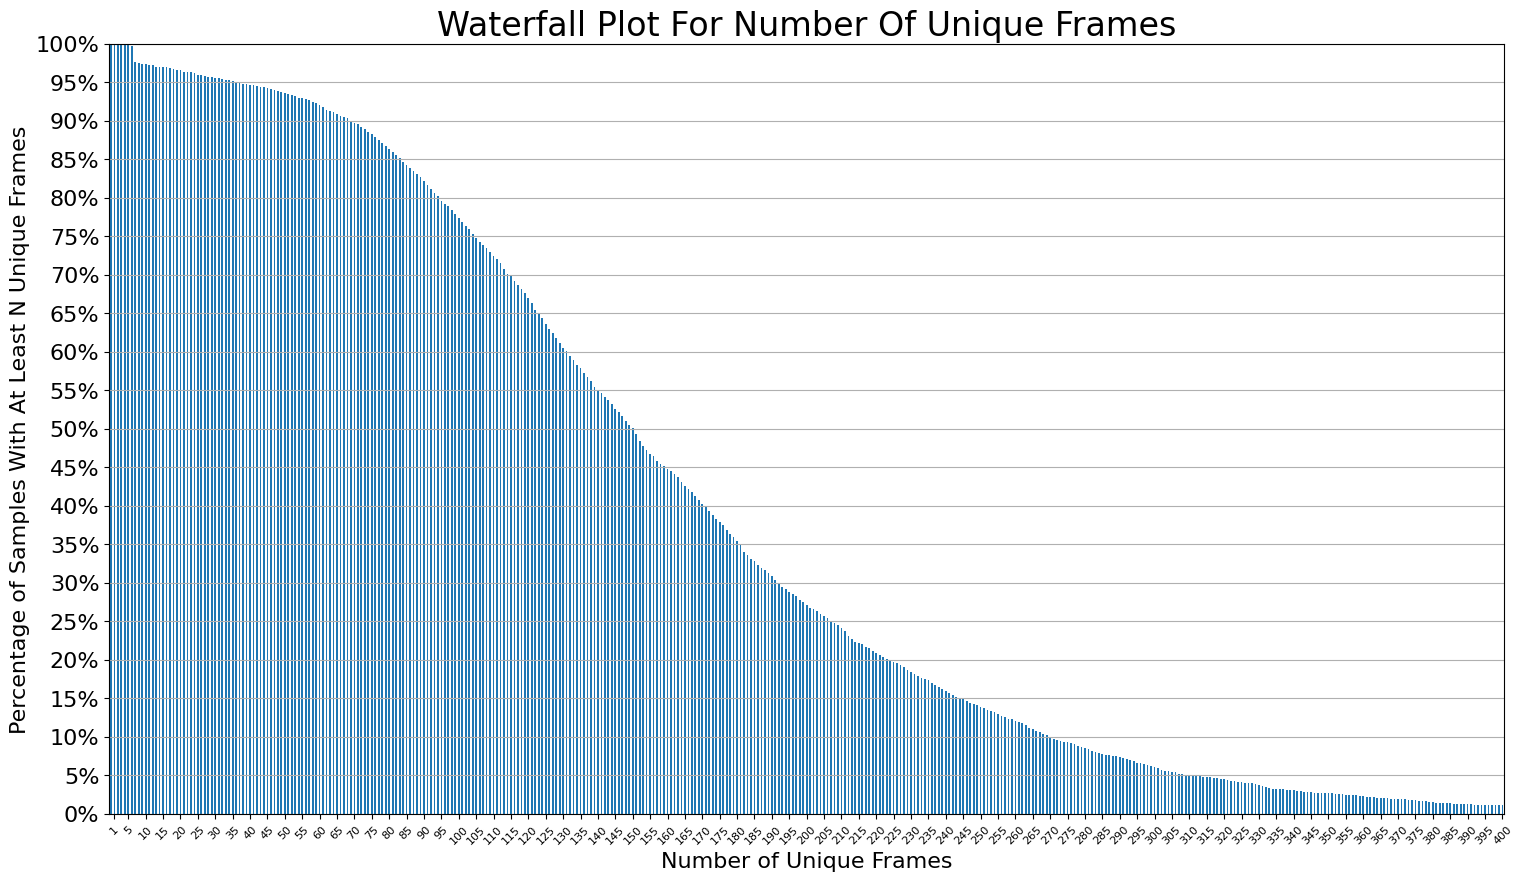

In [19]:
# With N_TARGET_FRAMES = 256 ~85% will be below
N_UNIQUE_FRAMES_WATERFALL = []
# Maximum Number of Unique Frames to use
N_MAX_UNIQUE_FRAMES = 400
# Compute Percentage
for n in tqdm(range(0,N_MAX_UNIQUE_FRAMES+1)):
    N_UNIQUE_FRAMES_WATERFALL.append(sum(N_UNIQUE_FRAMES >= n) / len(N_UNIQUE_FRAMES) * 100)

plt.figure(figsize=(18,10))
plt.title('Waterfall Plot For Number Of Unique Frames')
pd.Series(N_UNIQUE_FRAMES_WATERFALL).plot(kind='bar')
plt.grid(axis='y')
plt.xticks([1] + np.arange(5, N_MAX_UNIQUE_FRAMES+5, 5).tolist(), size=8, rotation=45)
plt.xlabel('Number of Unique Frames', size=16)
plt.yticks(np.arange(0, 100+5, 5), [f'{i}%' for i in range(0,100+5,5)])
plt.ylim(0, 100)
plt.ylabel('Percentage of Samples With At Least N Unique Frames', size=16)
plt.show()

## Landmark Indices


In [20]:
def get_idxs(df, words_pos, words_neg=[], ret_names=True, idxs_pos=None):
    idxs = []
    names = []
    for w in words_pos:
        for col_idx, col in enumerate(example_parquet_df.columns):
            # Exclude Non Landmark Columns
            if col in ['frame']:
                continue
                
            col_idx = int(col.split('_')[-1])
            # Check if column name contains all words
            if (w in col) and (idxs_pos is None or col_idx in idxs_pos) and all([w not in col for w in words_neg]):
                idxs.append(col_idx)
                names.append(col)
    # Convert to Numpy arrays
    idxs = np.array(idxs)
    names = np.array(names)
    # Returns either both column indices and names
    if ret_names:
        return idxs, names
    # Or only columns indices
    else:
        return idxs

In [21]:
# Lips Landmark Face Ids
LIPS_LANDMARK_IDXS = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])

# Landmark Indices for Left/Right hand without z axis in raw data
LEFT_HAND_IDXS0, LEFT_HAND_NAMES0 = get_idxs(example_parquet_df, ['left_hand'], ['z'])
RIGHT_HAND_IDXS0, RIGHT_HAND_NAMES0 = get_idxs(example_parquet_df, ['right_hand'], ['z'])
LIPS_IDXS0, LIPS_NAMES0 = get_idxs(example_parquet_df, ['face'], ['z'], idxs_pos=LIPS_LANDMARK_IDXS)
COLUMNS0 = np.concatenate((LEFT_HAND_NAMES0, RIGHT_HAND_NAMES0, LIPS_NAMES0))
N_COLS0 = len(COLUMNS0)
# Only X/Y axes are used
N_DIMS0 = 2

print(f'N_COLS0: {N_COLS0}')

N_COLS0: 164


In [22]:
# Landmark Indices in subset of dataframe with only COLUMNS selected
LEFT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, LEFT_HAND_NAMES0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(COLUMNS0, RIGHT_HAND_NAMES0)).squeeze()
LIPS_IDXS = np.argwhere(np.isin(COLUMNS0, LIPS_NAMES0)).squeeze()
N_COLS = N_COLS0
# Only X/Y axes are used
N_DIMS = 2

print(f'N_COLS: {N_COLS}')

N_COLS: 164


In [23]:
# Indices in processed data by axes with only dominant hand
HAND_X_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'x' in name]
    ).squeeze()
HAND_Y_IDXS = np.array(
        [idx for idx, name in enumerate(LEFT_HAND_NAMES0) if 'y' in name]
    ).squeeze()
# Names in processed data by axes
HAND_X_NAMES = LEFT_HAND_NAMES0[HAND_X_IDXS]
HAND_Y_NAMES = LEFT_HAND_NAMES0[HAND_Y_IDXS]

## Number Of Non-NaN Frames

In [24]:
"""
    Tensorflow layer to process data in TFLite
    Data needs to be processed in the model itself, so we can not use Python
""" 
class PreprocessLayerNonNaN(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayerNonNaN, self).__init__()
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_COLS0], dtype=tf.float32),),
    )
    def call(self, data0):
        # Fill NaN Values With 0
        data = tf.where(tf.math.is_nan(data0), 0.0, data0)
        
        # Hacky
        data = data[None]
        
        # Empty Hand Frame Filtering
        hands = tf.slice(data, [0,0,0], [-1, -1, 84])
        hands = tf.abs(hands)
        mask = tf.reduce_sum(hands, axis=2)
        mask = tf.not_equal(mask, 0)
        data = data[mask][None]
        data = tf.squeeze(data, axis=[0])
        
        return data
    
preprocess_layer_non_nan = PreprocessLayerNonNaN()

In [25]:
# Unique Parquet Files
UNIQUE_FILE_PATHS = pd.Series(train['file_path'].unique())
# Number of parquet chunks to analyse
N = 5 if (IS_INTERACTIVE or FAST) else len(UNIQUE_FILE_PATHS)
# Number of Non Nan Frames in Recording
N_NON_NAN_FRAMES = []

for idx, file_path in enumerate(tqdm(UNIQUE_FILE_PATHS.sample(N, random_state=SEED))):
    df = pd.read_parquet(file_path)
    for group, group_df in df.groupby('sequence_id'):
        frames = preprocess_layer_non_nan(group_df[COLUMNS0].values).numpy()
        N_NON_NAN_FRAMES.append(len(frames))

# Convert to Numpy Array
N_NON_NAN_FRAMES = pd.Series(N_NON_NAN_FRAMES).to_frame('# Frames')

  0%|          | 0/5 [00:00<?, ?it/s]

,# Frames
count,4996
mean,94
std,74
min,1
1%,1
5%,5
10%,11
25%,35
50%,82
75%,135


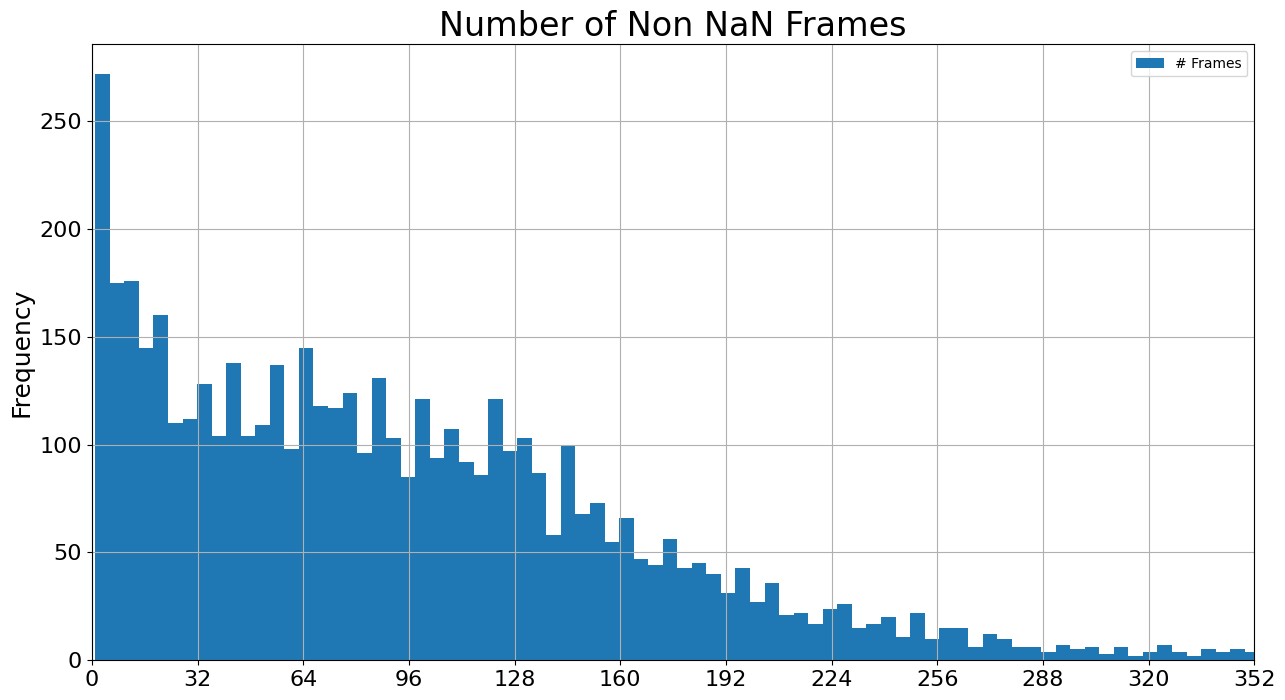

In [26]:
# Number of frames in each video with hand coordinates
display(N_NON_NAN_FRAMES.describe(percentiles=PERCENTILES).astype(int))

N_NON_NAN_FRAMES.plot(kind='hist', bins=128, figsize=(15,8))
plt.title('Number of Non NaN Frames', size=24)
plt.grid()
xlim = np.percentile(N_NON_NAN_FRAMES, 99)
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim+32, 32))
plt.show()

## Tensorflow Preprocess Layer

In [27]:
"""
    Tensorflow layer to process data in TFLite
    Data needs to be processed in the model itself, so we can not use Python
""" 
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        self.normalisation_correction = tf.constant(
                    # Add 0.50 to x coordinates of left hand (original right hand) and substract 0.50 of right hand (original left hand)
                     [0.50 if 'x' in name else 0.00 for name in LEFT_HAND_NAMES0],
                dtype=tf.float32,
            )
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_COLS0], dtype=tf.float32),),
    )
    def call(self, data0, resize=True):
        # Fill NaN Values With 0
        data = tf.where(tf.math.is_nan(data0), 0.0, data0)
        
        # Hacky
        data = data[None]
        
        # Empty Hand Frame Filtering
        hands = tf.slice(data, [0,0,0], [-1, -1, 84])
        hands = tf.abs(hands)
        mask = tf.reduce_sum(hands, axis=2)
        mask = tf.not_equal(mask, 0)
        data = data[mask][None]
        
        # Pad Zeros
        N_FRAMES = len(data[0])
        if N_FRAMES < N_TARGET_FRAMES:
            data = tf.concat((
                data,
                tf.zeros([1,N_TARGET_FRAMES-N_FRAMES,N_COLS], dtype=tf.float32)
            ), axis=1)
        # Downsample
        data = tf.image.resize(
            data,
            [1, N_TARGET_FRAMES],
            method=tf.image.ResizeMethod.BILINEAR,
        )
        
        # Squeeze Batch Dimension
        data = tf.squeeze(data, axis=[0])
        
        return data
    
preprocess_layer = PreprocessLayer()

inputs = group_df[COLUMNS0].values
inputs = inputs[:1]

frames = preprocess_layer(inputs)

print(f'inputs shape: {inputs.shape}')
print(f'frames shape: {frames.shape}, NaN count: {np.isnan(frames).sum()}')

inputs shape: (1, 164)
frames shape: (128, 164), NaN count: 0


## Create X/Y

In [28]:
# Target Arrays Processed Input Videos
X = np.zeros([N_SAMPLES, N_TARGET_FRAMES, N_COLS], dtype=np.float32)
# Ordinally Encoded Target With value 59 for pad token
y = np.full(shape=[N_SAMPLES, N_TARGET_FRAMES], fill_value=N_UNIQUE_CHARACTERS, dtype=np.int8)
# Phrase Type
y_phrase_type = np.empty(shape=[N_SAMPLES], dtype=object)

In [29]:
# All Unique Parquet Files
UNIQUE_FILE_PATHS = pd.Series(train['file_path'].unique())
N_UNIQUE_FILE_PATHS = len(UNIQUE_FILE_PATHS)
# Counter to keep track of sample
row = 0
count = 0
# Compressed Parquet Files
Path('train_landmark_subsets').mkdir(parents=True, exist_ok=True)
# Numbre Of Frames Per Character
N_FRAMES_PER_CHARACTER = []
# Minimum Number Of Frames Per Character
MIN_NUM_FRAMES_PER_CHARACTER = 4
VALID_IDXS = []

# Fill Arrays
for idx, file_path in enumerate(tqdm(UNIQUE_FILE_PATHS)):
    # Progress Logging
    print(f'Processed {idx:02d}/{N_UNIQUE_FILE_PATHS} parquet files')
    # Read parquet file
    df = pd.read_parquet(file_path)
    # Save COLUMN Subset of parquet files for TFLite Model verficiation
    name = file_path.split('/')[-1]
    if idx < 10:
        df[COLUMNS0].to_parquet(f'train_landmark_subsets/{name}', engine='pyarrow', compression='zstd')
    # Iterate Over Samples
    for group, group_df in df.groupby('sequence_id'):
        # Number of Frames Per Character
        n_frames_per_character =  len(group_df[COLUMNS0].values) / len(train_sequence_id.loc[group, 'phrase_char'])
        N_FRAMES_PER_CHARACTER.append(n_frames_per_character)
        if n_frames_per_character < MIN_NUM_FRAMES_PER_CHARACTER:
            count = count + 1
            continue
        else:
            # Add Valid Index
            VALID_IDXS.append(count)
            count = count + 1
        
        # Get Processed Frames and non empty frame indices
        frames = preprocess_layer(group_df[COLUMNS0].values)
        assert frames.ndim == 2
        # Assign
        X[row] = frames
        # Add Target By Ordinally Encoding Characters
        phrase_char = train_sequence_id.loc[group, 'phrase_char']
        for col, char in enumerate(phrase_char):
            y[row, col] = CHAR2ORD.get(char)
        # Add EOS Token
        y[row, col+1] = EOS_TOKEN
        # Phrase Type
        y_phrase_type[row] = train_sequence_id.loc[group, 'phrase_type']
        # Row Count
        row += 1
    # clean up
    gc.collect()

  0%|          | 0/68 [00:00<?, ?it/s]

Processed 00/68 parquet files
Processed 01/68 parquet files
Processed 02/68 parquet files
Processed 03/68 parquet files
Processed 04/68 parquet files
Processed 05/68 parquet files
Processed 06/68 parquet files
Processed 07/68 parquet files
Processed 08/68 parquet files
Processed 09/68 parquet files
Processed 10/68 parquet files
Processed 11/68 parquet files
Processed 12/68 parquet files
Processed 13/68 parquet files
Processed 14/68 parquet files
Processed 15/68 parquet files
Processed 16/68 parquet files
Processed 17/68 parquet files
Processed 18/68 parquet files
Processed 19/68 parquet files
Processed 20/68 parquet files
Processed 21/68 parquet files
Processed 22/68 parquet files
Processed 23/68 parquet files
Processed 24/68 parquet files
Processed 25/68 parquet files
Processed 26/68 parquet files
Processed 27/68 parquet files
Processed 28/68 parquet files
Processed 29/68 parquet files
Processed 30/68 parquet files
Processed 31/68 parquet files
Processed 32/68 parquet files
Processed 

In [30]:
# rows denotes the number of samples with frames/character above threshold
print(f'row: {row}, count: {count}')

row: 61955, count: 67208


In [31]:
# Example target, note the phrase is padded with the pad token 59
print(f'Example Target: {y[0]}')

Example Target: [18  0 34 49 36 36 42 39 46 52 50 36 61 62 62 62 62 62 62 62 62 62 62 62
 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62
 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62
 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62
 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62
 62 62 62 62 62 62 62 62]


In [32]:
# Filer X/y
X = X[:row]
y = y[:row]

In [33]:
# Save X/y
np.save('X.npy', X)
np.save('y.npy', y)
# Save Validation
splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=SEED)
PARTICIPANT_IDS = train['participant_id'].values[VALID_IDXS]
train_idxs, val_idxs = next(splitter.split(X, y, groups=PARTICIPANT_IDS))

# Save Train
np.save('X_train.npy', X[train_idxs])
np.save('y_train.npy', y[train_idxs])
# Save Validation
np.save('X_val.npy', X[val_idxs])
np.save('y_val.npy', y[val_idxs])
# Verify Train/Val is correctly split by participan id
print(f'Patient ID Intersection Train/Val: {set(PARTICIPANT_IDS[train_idxs]).intersection(PARTICIPANT_IDS[val_idxs])}')
# Train/Val Sizes
print(f'# Train Samples: {len(train_idxs)}, # Val Samples: {len(val_idxs)}')

Patient ID Intersection Train/Val: set()
# Train Samples: 54719, # Val Samples: 7236


## Number of Frames Per Character

,Value
count,67208.00
mean,9.02
std,3.84
min,0.03
1%,0.33
5%,2.38
10%,4.62
25%,6.75
50%,8.86
75%,11.18


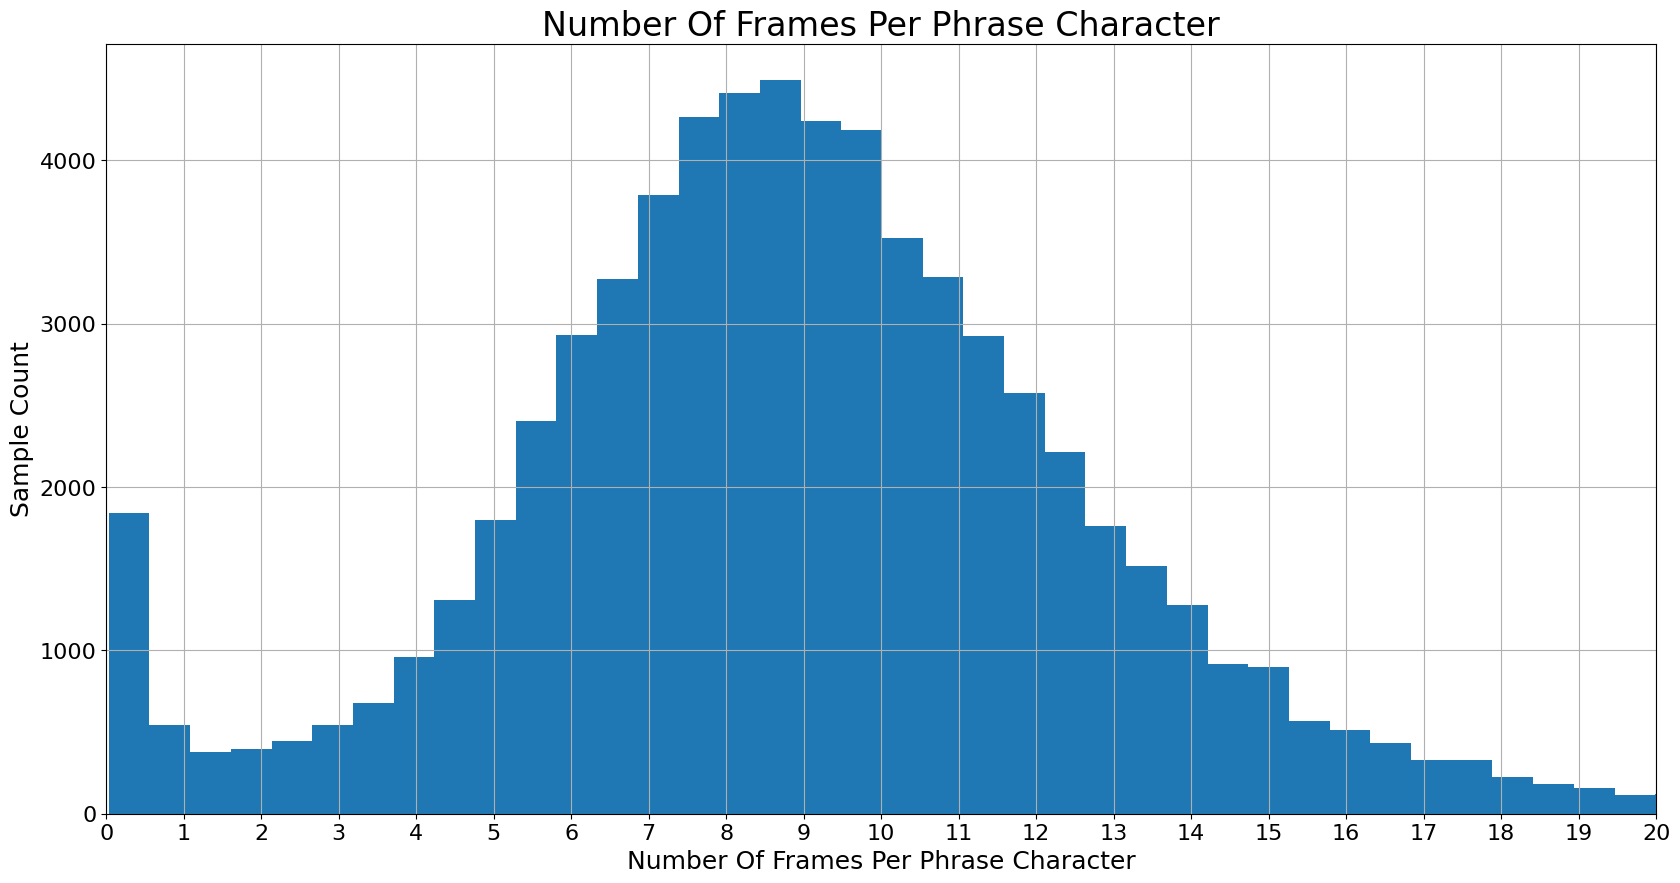

In [34]:
N_FRAMES_PER_CHARACTER_S = pd.Series(N_FRAMES_PER_CHARACTER)

display(N_FRAMES_PER_CHARACTER_S.describe(percentiles=PERCENTILES).to_frame('Value').round(2))

plt.figure(figsize=(20,10))
plt.title('Number Of Frames Per Phrase Character')
N_FRAMES_PER_CHARACTER_S.plot(kind='hist', bins=128)
# Plot till 99th percentile
p99 = math.ceil(np.percentile(N_FRAMES_PER_CHARACTER_S, 99))
plt.xticks(np.arange(0, p99+1, 1))
plt.xlim(0, p99)
plt.xlabel('Number Of Frames Per Phrase Character')
plt.ylabel('Sample Count')
plt.grid()
plt.show()

## Coordinate Statistics

  0%|          | 0/164 [00:00<?, ?it/s]

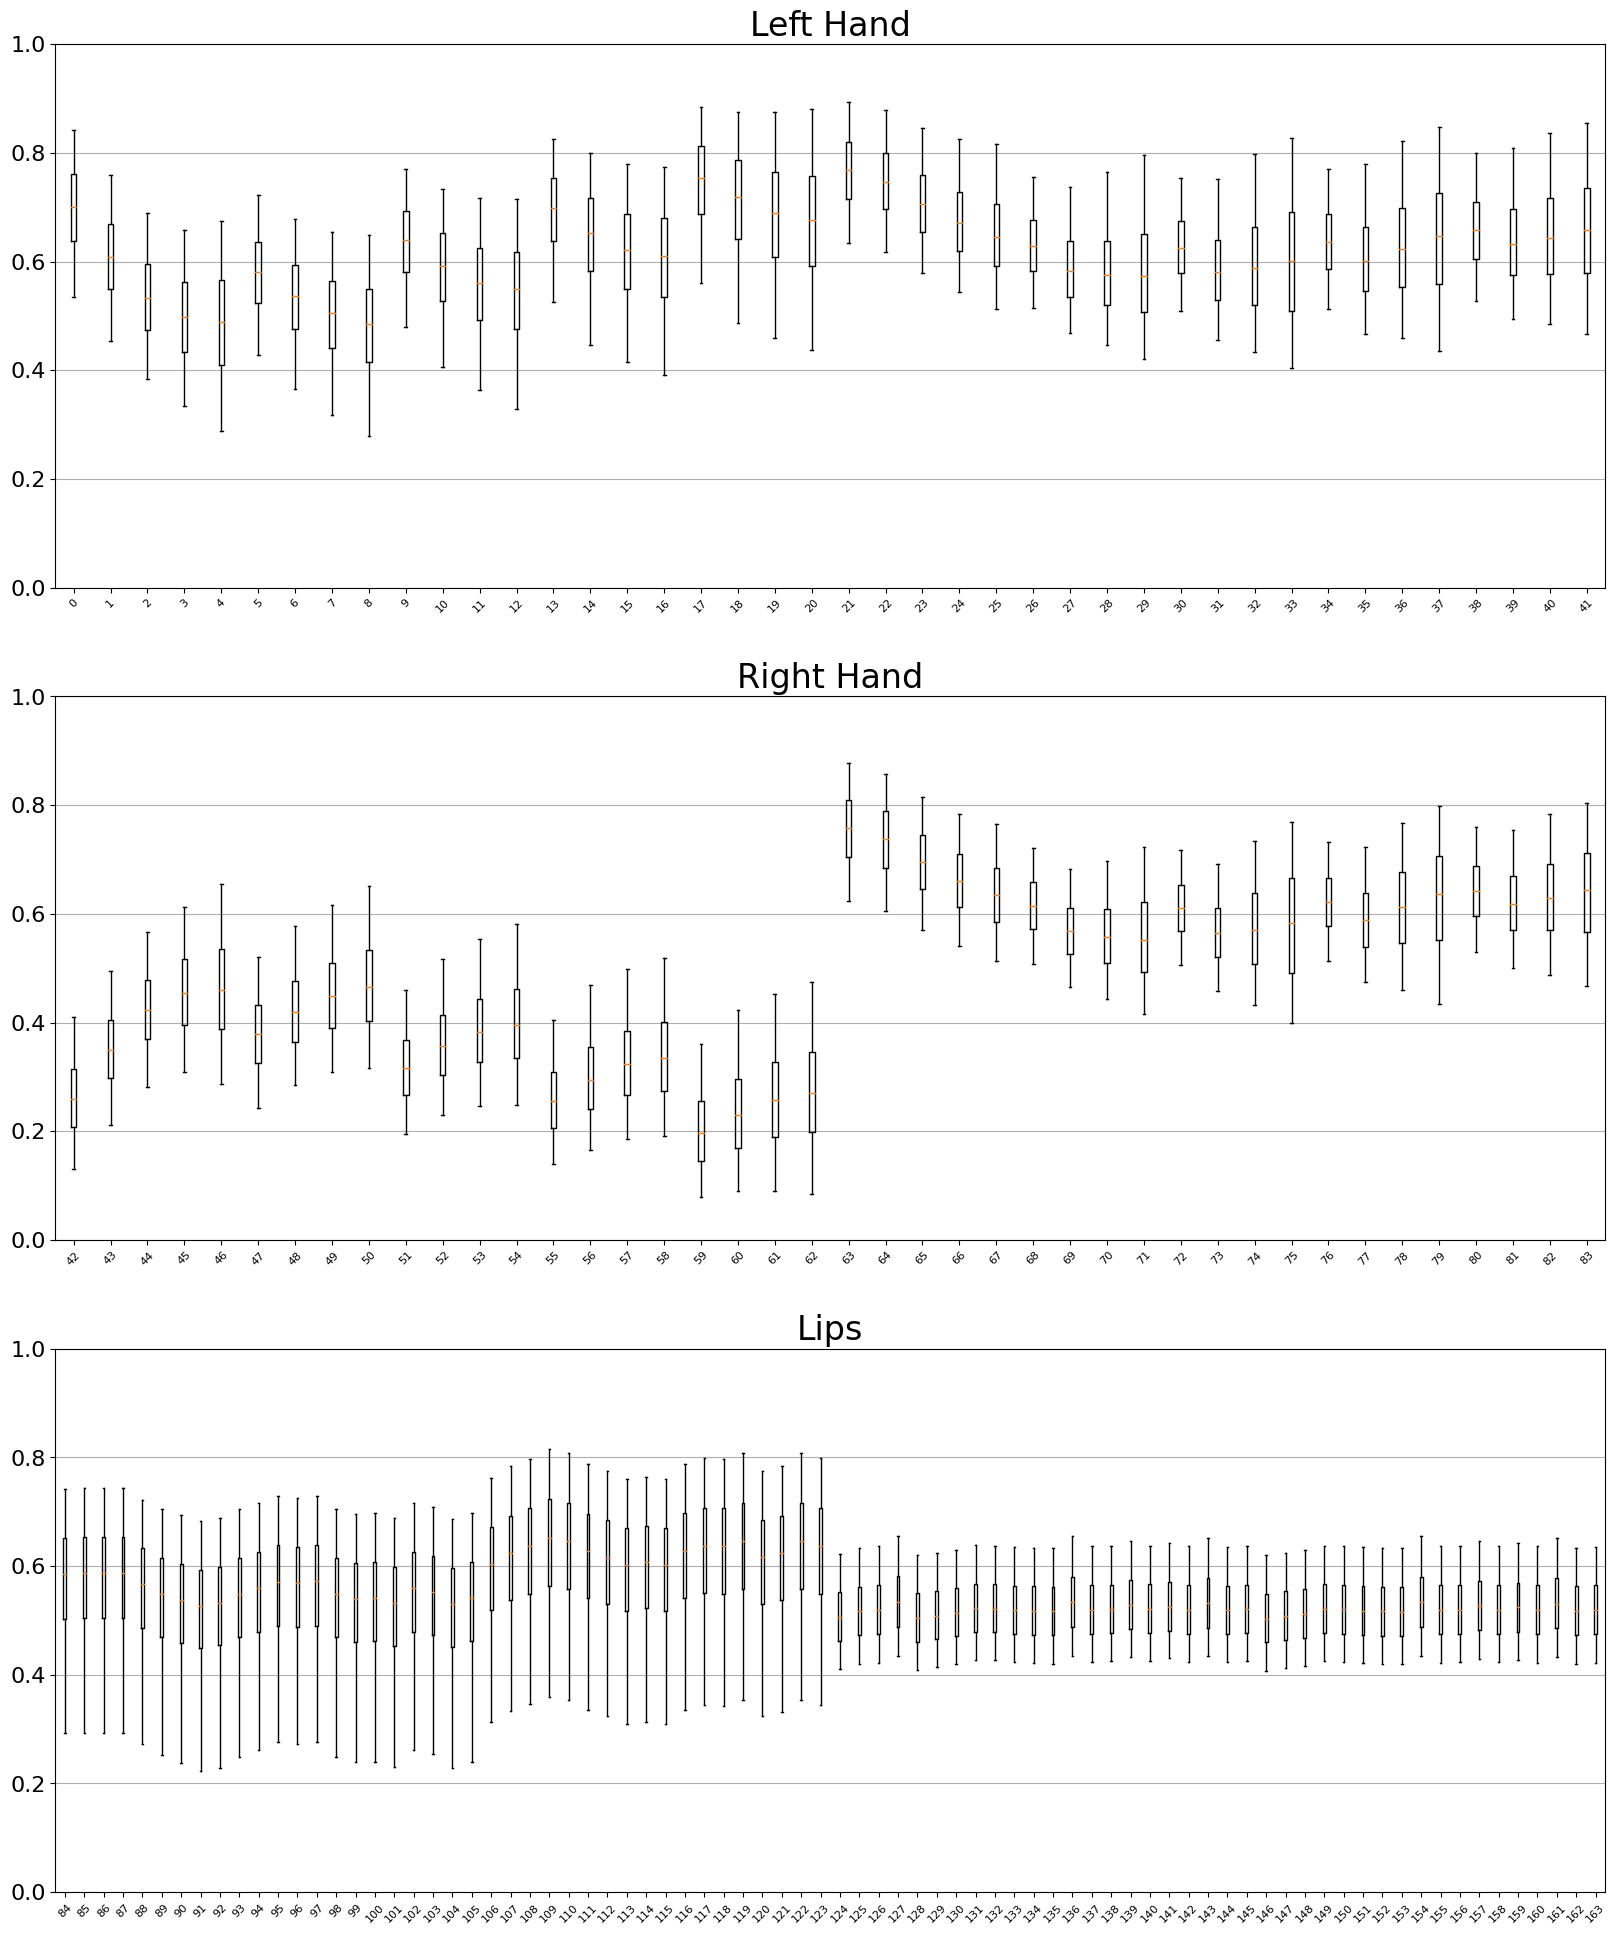

In [35]:
def get_left_right_hand_mean_std():
    # Dominant Hand Statistics
    MEANS = np.zeros([N_COLS], dtype=np.float32)
    STDS = np.zeros([N_COLS], dtype=np.float32)
    
    # Plot
    fig, axes = plt.subplots(3, figsize=(20, 3*8))
    
    # Iterate over all landmarks
    for col, v in enumerate(tqdm(X.reshape([-1, N_COLS]).T)):
        v = v[np.nonzero(v)]
        # Remove zero values as they are NaN values
        MEANS[col] = v.astype(np.float32).mean()
        STDS[col] = v.astype(np.float32).std()
        if col in LEFT_HAND_IDXS:
            axes[0].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        elif col in RIGHT_HAND_IDXS:
            axes[1].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        else:
            axes[2].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])
        
    for ax, name in zip(axes, ['Left Hand', 'Right Hand', 'Lips']):
        ax.set_title(f'{name}', size=24)
        ax.tick_params(axis='x', labelsize=8, rotation=45)
        ax.set_ylim(0.0, 1.0)
        ax.grid(axis='y')

    plt.show()
    
    return MEANS, STDS

# Get Dominant Hand Mean/Standard Deviation
MEANS, STDS = get_left_right_hand_mean_std()
# Save Mean/STD to normalize input in neural network model
np.save('MEANS.npy', MEANS)
np.save('STDS.npy', STDS)

# Load X/y

In [36]:
# Train/Validation
if USE_VAL:
    # TRAIN
    X_train = np.load('/kaggle/input/aslfr-preprocessing-dataset/X_train.npy')
    y_train = np.load('/kaggle/input/aslfr-preprocessing-dataset/y_train.npy')[:,:MAX_PHRASE_LENGTH]
    N_TRAIN_SAMPLES = len(X_train)
    # VAL
    X_val = np.load('/kaggle/input/aslfr-preprocessing-dataset/X_val.npy')
    y_val = np.load('/kaggle/input/aslfr-preprocessing-dataset/y_val.npy')[:,:MAX_PHRASE_LENGTH]
    N_VAL_SAMPLES = len(X_val)
    # Shapes
    print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}')
# Train On All Data
else:
    # TRAIN
    X_train = np.load('/kaggle/input/aslfr-preprocessing-dataset/X.npy')
    y_train = np.load('/kaggle/input/aslfr-preprocessing-dataset/y.npy')[:,:MAX_PHRASE_LENGTH]
    N_TRAIN_SAMPLES = len(X_train)
    print(f'X_train shape: {X_train.shape}')

X_train shape: (54719, 128, 164), X_val shape: (7236, 128, 164)


# Example Batch

In [37]:
# Example Batch For Debugging
N_EXAMPLE_BATCH_SAMPLES = 1024
N_EXAMPLE_BATCH_SAMPLES_SMALL = 32
# Example Batch
X_batch = {
    'frames': np.copy(X_train[:N_EXAMPLE_BATCH_SAMPLES]),
    'phrase': np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES]),
#     'phrase_type': np.copy(y_phrase_type_train[:N_EXAMPLE_BATCH_SAMPLES]),
}
y_batch = np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES])
# Small Example Batch
X_batch_small = {
    'frames': np.copy(X_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
    'phrase': np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
#     'phrase_type': np.copy(y_phrase_type_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL]),
}
y_batch_small = np.copy(y_train[:N_EXAMPLE_BATCH_SAMPLES_SMALL])

# Mean/STD Loading

In [38]:
# Mean/Standard Deviations of data used for normalizing
MEANS = np.load('/kaggle/input/aslfr-preprocessing-dataset/MEANS.npy').reshape(-1)
STDS = np.load('/kaggle/input/aslfr-preprocessing-dataset/STDS.npy').reshape(-1)

# Test Preprocessing Layer

In [39]:
# Function To Test Preprocessing Layer
def test_preprocess_layer():
    demo_sequence_id = example_parquet_df.index.unique()[15]
    demo_raw_data = example_parquet_df.loc[demo_sequence_id, COLUMNS0]
    data = preprocess_layer(demo_raw_data)

    print(f'demo_raw_data shape: {demo_raw_data.shape}')
    print(f'data shape: {data.shape}')
    
    return data
    
if IS_INTERACTIVE:
    data = test_preprocess_layer()

demo_raw_data shape: (159, 164)
data shape: (128, 164)


# Train Dataset

In [40]:
# Train Dataset Iterator
def get_train_dataset(X, y, batch_size=BATCH_SIZE):
    sample_idxs = np.arange(len(X))
    while True:
        # Get random indices
        random_sample_idxs = np.random.choice(sample_idxs, batch_size)
        
        inputs = {
            'frames': X[random_sample_idxs],
            'phrase': y[random_sample_idxs],
        }
        outputs = y[random_sample_idxs]
        
        yield inputs, outputs

In [41]:
# Train Dataset
train_dataset = get_train_dataset(X_train, y_train)

In [42]:
# Training Steps Per Epoch
TRAIN_STEPS_PER_EPOCH = math.ceil(N_TRAIN_SAMPLES / BATCH_SIZE)
print(f'TRAIN_STEPS_PER_EPOCH: {TRAIN_STEPS_PER_EPOCH}')

TRAIN_STEPS_PER_EPOCH: 855


# Validation Dataset

In [43]:
# Validation Set
def get_val_dataset(X, y, batch_size=BATCH_SIZE):
    offsets = np.arange(0, len(X), batch_size)
    while True:
        # Iterate over whole validation set
        for offset in offsets:
            inputs = {
                'frames': X[offset:offset+batch_size],
                'phrase': y[offset:offset+batch_size],
            }
            outputs = y[offset:offset+batch_size]

            yield inputs, outputs

In [44]:
# Validation Dataset
if USE_VAL:
    val_dataset = get_val_dataset(X_val, y_val)

In [45]:
if USE_VAL:
    N_VAL_STEPS_PER_EPOCH = math.ceil(N_VAL_SAMPLES / BATCH_SIZE)
    print(f'N_VAL_STEPS_PER_EPOCH: {N_VAL_STEPS_PER_EPOCH}')

N_VAL_STEPS_PER_EPOCH: 114


# Model Config

In [ ]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# final embedding and transformer embedding size
UNITS_ENCODER = 384 #Dimesion of Encoder
UNITS_DECODER = 256 #Dimesion of Dncoder

# Transformer
NUM_BLOCKS_ENCODER = 4 #Encoder Blocks 
NUM_BLOCKS_DECODER = 2 #Decoder Blocks
NUM_HEADS = 4 # Number of Attention Heads
MLP_RATIO = 2 # Multi Layer Perception Ration

# Dropout
EMBEDDING_DROPOUT = 0.00 #Embedding Dropout Ration 
MLP_DROPOUT_RATIO = 0.30 #Multi Layer Perception Dropout Ratio
MHA_DROPOUT_RATIO = 0.20 #MultiHead Attention Dropout Ration
CLASSIFIER_DROPOUT_RATIO = 0.10 # Classifier Dropout Ration

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform #He Uniform Weights Initializer, It helps avoid the vanishing/exploding gradient problems at the start of the training. 
                                                   #By maintaining a controlled variance, it ensures that the signals don't get too small or too large during the initial stages.

INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform #Glorot Uniform Initializer By maintaining the variance of activations and back-propagated gradients, it helps avoid the vanishing/exploding gradient problem, 
                                                           #especially in deep networks. 
                                                           #It's suitable for networks with sigmoid or hyperbolic tangent activation functions.

INIT_ZEROS = tf.keras.initializers.constant(0.0) #Zeros Initializer It initializes the weights to all zeros.

# Activations
GELU = tf.keras.activations.gelu #Gaussian Error Linear Unit activation function.

# Landmark Embedding

In [47]:
# Embeds a landmark using fully connected layers
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        self.supports_masking = True
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM, activation=GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

# Embedding

In [48]:
# Creates embedding for each frame
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        self.supports_masking = True
    
    def build(self, input_shape):
        # Positional embedding for each frame index
        self.positional_embedding = tf.Variable(
            initial_value=tf.zeros([N_TARGET_FRAMES, UNITS_ENCODER], dtype=tf.float32),
            trainable=True,
            name='embedding_positional_encoder',
        )
        # Embedding layer for Landmarks
        self.dominant_hand_embedding = LandmarkEmbedding(UNITS_ENCODER, 'dominant_hand')

    def call(self, x, training=False):
        # Normalize
        x = tf.where(
                tf.math.equal(x, 0.0),
                0.0,
                (x - MEANS) / STDS,
            )
        # Dominant Hand
        x = self.dominant_hand_embedding(x)
        # Add Positional Encoding
        x = x + self.positional_embedding
        
        return x

# Transformer

In [49]:
# based on: https://stackoverflow.com/questions/67342988/verifying-the-implementation-of-multihead-attention-in-transformer
# replaced softmax with softmax layer to support masked softmax
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, dropout, d_out=None):
        super(MultiHeadAttention,self).__init__()
        # Number of Units in Model
        self.d_model = d_model
        # Number of Attention Heads
        self.n_heads = n_heads
        # Number of Units in Intermediate Layers
        self.depth = d_model // 2
        # Scaling Factor Of Values
        self.scale = 1.0 / tf.math.sqrt(tf.cast(self.depth, tf.float32))
        # Learnable Projections to Depth
        self.wq = self.fused_mha(self.depth)
        self.wk = self.fused_mha(self.depth)
        self.wv = self.fused_mha(self.depth)
        # Output Projection
        self.wo = tf.keras.layers.Dense(d_model if d_out is None else d_out, use_bias=False)
        # Softmax Activation Which Supports Masking
        self.softmax = tf.keras.layers.Softmax()
        # Reshaping Of Multiple Attention heads to Single Value
        self.reshape = tf.keras.Sequential([
            # [attention heads, number of frames, d_model] → [number of frames, n_heads, d_model // n_heads]
            tf.keras.layers.Permute([2, 1, 3]),
            # [number of frames, attention heads, d_model] → [number of frames, d_model]
            tf.keras.layers.Reshape([N_TARGET_FRAMES, self.depth]),
        ])
        # Output Dropout
        self.do = tf.keras.layers.Dropout(dropout)
        self.supports_masking = True
        
    # Single dense layer for all attention heads
    def fused_mha(self, dim):
        return tf.keras.Sequential([
            # Single dense layer
            tf.keras.layers.Dense(dim, use_bias=False),
            # Reshape to [number of frames, number of attention head, depth]
            tf.keras.layers.Reshape([N_TARGET_FRAMES, self.n_heads, dim // self.n_heads]),
            # Permutate to [number of attention heads, number of frames, depth]
            tf.keras.layers.Permute([2, 1, 3]),
        ])
        
    def call(self, q, k, v, attention_mask=None, training=False):
        # Projections to attention heads
        Q = self.wq(q)
        K = self.wk(k)
        V = self.wv(v)
        # Matrix multiply QxK to acquire attention scores
        x = tf.matmul(Q, K, transpose_b=True) * self.scale
        # Softmax attention scores and Multiply with Values
        x = self.softmax(x, mask=attention_mask) @ V
        # Reshape to flatten attention heads
        x = self.reshape(x)
        # Output projection
        x = self.wo(x)
        # Dropout
        x = self.do(x, training=training)
        return x

# Encoder

[source](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/)

In [50]:
# Encoder based on multiple transformer blocks
class Encoder(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Encoder, self).__init__(name='encoder')
        self.num_blocks = num_blocks
        self.supports_masking = True
    
    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # First Layer Normalisation
            self.ln_1s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS_ENCODER, NUM_HEADS, MHA_DROPOUT_RATIO))
            # Second Layer Normalisation
            self.ln_2s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS_ENCODER * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS_ENCODER, kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
            ]))
            # Optional Projection to Decoder Dimension
            if UNITS_ENCODER != UNITS_DECODER:
                self.dense_out = tf.keras.layers.Dense(UNITS_DECODER, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False)
                self.apply_dense_out = True
            else:
                self.apply_dense_out = False
                
    def get_attention_mask(self, x_inp):
        # Attention Mask
        attention_mask = tf.math.count_nonzero(x_inp, axis=[2], keepdims=True, dtype=tf.int32)
        attention_mask = tf.math.count_nonzero(attention_mask, axis=[2], keepdims=False)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        return attention_mask
        
    def call(self, x, x_inp, training=False):
        # Attention mask to ignore missing frames
        attention_mask = self.get_attention_mask(x_inp)
        # Iterate input over transformer blocks
        for ln_1, mha, ln_2, mlp in zip(self.ln_1s, self.mhas, self.ln_2s, self.mlps):
            x = ln_1(x + mha(x, x, x, attention_mask=attention_mask))
            x = ln_2(x + mlp(x))
            
        # Optional Projection to Decoder Dimension
        if self.apply_dense_out:
            x = self.dense_out(x)
    
        return x

# Decoder

In [51]:
# Decoder based on multiple transformer blocks
class Decoder(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Decoder, self).__init__(name='decoder')
        self.num_blocks = num_blocks
        self.supports_masking = True
    
    def build(self, input_shape):
        # Causal Mask Batch Size 1
        self.causal_mask = self.get_causal_attention_mask()
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.Variable(
            initial_value=tf.zeros([N_TARGET_FRAMES, UNITS_DECODER], dtype=tf.float32),
            trainable=True,
            name='embedding_positional_encoder',
        )
        # Character Embedding
        self.char_emb = tf.keras.layers.Embedding(N_UNIQUE_CHARACTERS, UNITS_DECODER, embeddings_initializer=INIT_ZEROS)
        # Positional Encoder MHA
        self.pos_emb_mha = MultiHeadAttention(UNITS_DECODER, NUM_HEADS, MHA_DROPOUT_RATIO)
        self.pos_emb_ln = tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        # First Layer Normalisation
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # First Layer Normalisation
            self.ln_1s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS_DECODER, NUM_HEADS, MHA_DROPOUT_RATIO))
            # Second Layer Normalisation
            self.ln_2s.append(tf.keras.layers.LayerNormalization(epsilon=LAYER_NORM_EPS))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS_DECODER * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM, use_bias=False),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS_DECODER, kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
            ]))
            
    def get_causal_attention_mask(self):
        i = tf.range(N_TARGET_FRAMES)[:, tf.newaxis]
        j = tf.range(N_TARGET_FRAMES)
        mask = tf.cast(i >= j, dtype=tf.int32)
        mask = tf.reshape(mask, (1, N_TARGET_FRAMES, N_TARGET_FRAMES))
        mult = tf.concat(
            [tf.expand_dims(1, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        mask = tf.tile(mask, mult)
        mask = tf.cast(mask, tf.float32)
        return mask
    
    def get_attention_mask(self, x_inp):
        # Attention Mask
        attention_mask = tf.math.count_nonzero(x_inp, axis=[2], keepdims=True, dtype=tf.int32)
        attention_mask = tf.math.count_nonzero(attention_mask, axis=[2], keepdims=False)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        attention_mask = tf.expand_dims(attention_mask, axis=1)
        return attention_mask
        
    def call(self, encoder_outputs, phrase, x_inp, training=False):
        # Batch Size
        B = tf.shape(encoder_outputs)[0]
        # Cast to INT32
        phrase = tf.cast(phrase, tf.int32)
        # Prepend SOS Token
        phrase = tf.pad(phrase, [[0,0], [1,0]], constant_values=SOS_TOKEN, name='prepend_sos_token')
        # Pad With PAD Token
        phrase = tf.pad(phrase, [[0,0], [0,N_TARGET_FRAMES-MAX_PHRASE_LENGTH-1]], constant_values=PAD_TOKEN, name='append_pad_token')
        # Positional Embedding
        x = self.positional_embedding + self.char_emb(phrase)
        # Causal Attention
        x = self.pos_emb_ln(x + self.pos_emb_mha(x, x, x, attention_mask=self.causal_mask))
        # Attention mask to ignore missing frames
        attention_mask = self.get_attention_mask(x_inp)
        # Iterate input over transformer blocks
        for ln_1, mha, ln_2, mlp in zip(self.ln_1s, self.mhas, self.ln_2s, self.mlps):
            x = ln_1(x + mha(x, encoder_outputs, encoder_outputs, attention_mask=attention_mask))
            x = ln_2(x + mlp(x))
        # Slice 31 Characters
        x = tf.slice(x, [0, 0, 0], [-1, MAX_PHRASE_LENGTH, -1])
    
        return x

In [52]:
# Causal Attention to make decoder not attent to future characters which it needs to predict
def get_causal_attention_mask(B):
    i = tf.range(N_TARGET_FRAMES)[:, tf.newaxis]
    j = tf.range(N_TARGET_FRAMES)
    mask = tf.cast(i >= j, dtype=tf.int32)
    mask = tf.reshape(mask, (1, N_TARGET_FRAMES, N_TARGET_FRAMES))
    mult = tf.concat(
        [tf.expand_dims(B, -1), tf.constant([1, 1], dtype=tf.int32)],
        axis=0,
    )
    mask = tf.tile(mask, mult)
    mask = tf.cast(mask, tf.float32)
    return mask

get_causal_attention_mask(1)

<tf.Tensor: shape=(1, 128, 128), dtype=float32, numpy=
array([[[1., 0., 0., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 0., 0.],
        [1., 1., 1., ..., 1., 1., 0.],
        [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)>

# Non Pad/SOS/EOS Token Accuracy

In [53]:
# TopK accuracy for multi dimensional output
class TopKAccuracy(tf.keras.metrics.Metric):
    def __init__(self, k, **kwargs):
        super(TopKAccuracy, self).__init__(name=f'top{k}acc', **kwargs)
        self.top_k_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=k)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1, N_UNIQUE_CHARACTERS])
        character_idxs = tf.where(y_true < N_UNIQUE_CHARACTERS0)
        y_true = tf.gather(y_true, character_idxs, axis=0)
        y_pred = tf.gather(y_pred, character_idxs, axis=0)
        self.top_k_acc.update_state(y_true, y_pred)

    def result(self):
        return self.top_k_acc.result()
    
    def reset_state(self):
        self.top_k_acc.reset_state()

# Loss Weights

In [54]:
# Create Initial Loss Weights All Set To 1
loss_weights = np.ones(N_UNIQUE_CHARACTERS, dtype=np.float32)
# Set Loss Weight Of Pad Token To 0
loss_weights[PAD_TOKEN-1] = 0

# Sparse Categorical Crossentropy With Label Smoothing¶

In [55]:
# source:: https://stackoverflow.com/questions/60689185/label-smoothing-for-sparse-categorical-crossentropy
def scce_with_ls(y_true, y_pred):
    # Filter Pad Tokens
    idxs = tf.where(y_true != PAD_TOKEN)
    y_true = tf.gather_nd(y_true, idxs)
    y_pred = tf.gather_nd(y_pred, idxs)
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, N_UNIQUE_CHARACTERS, axis=1)
    # Categorical Crossentropy with native label smoothing support
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25, from_logits=True)
    loss = tf.math.reduce_mean(loss)
    return loss

# Model

In [56]:
def get_model():
    # Inputs
    frames_inp = tf.keras.layers.Input([N_TARGET_FRAMES, N_COLS], dtype=tf.float32, name='frames')
    phrase_inp = tf.keras.layers.Input([MAX_PHRASE_LENGTH], dtype=tf.int32, name='phrase')
    # Frames
    x = frames_inp

    # Masking
    x = tf.keras.layers.Masking(mask_value=0.0, input_shape=(N_TARGET_FRAMES, N_COLS))(x)
    
    # Embedding
    x = Embedding()(x)
    
    # Encoder Transformer Blocks
    x = Encoder(NUM_BLOCKS_ENCODER)(x, frames_inp)
    
    # Decoder
    x = Decoder(NUM_BLOCKS_DECODER)(x, phrase_inp, frames_inp)
    
    # Classifier
    x = tf.keras.Sequential([
        # Dropout
        tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO),
        # Output Neurons
        tf.keras.layers.Dense(N_UNIQUE_CHARACTERS, activation=tf.keras.activations.linear, kernel_initializer=INIT_HE_UNIFORM, use_bias=False),
    ], name='classifier')(x)
    
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames_inp, phrase_inp], outputs=outputs)
    
    # Categorical Crossentropy Loss With Label Smoothing
    loss = scce_with_ls
    
    # Adam Optimizer
    optimizer = tfa.optimizers.RectifiedAdam(sma_threshold=4)
    optimizer = tfa.optimizers.Lookahead(optimizer, sync_period=5)

    # TopK Metrics
    metrics = [
        TopKAccuracy(1),
        TopKAccuracy(5),
    ]
    
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics,
        loss_weights=loss_weights,
    )
    
    return model

In [57]:
# Input data
for k, v in X_batch.items():
    print(f'{k}: {v.shape}')

frames: (1024, 128, 164)
phrase: (1024, 31)


In [58]:
tf.keras.backend.clear_session()

model = get_model()

In [59]:
# Plot model summary
model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 frames (InputLayer)         [(None, 128, 164)]           0         []                            
                                                                                                  
 masking (Masking)           (None, 128, 164)             0         ['frames[0][0]']              
                                                                                                  
 embedding (Embedding)       (None, 128, 384)             259968    ['masking[0][0]']             
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| dominant_hand_embedding (  multiple                     210816    []                           |
| LandmarkEmbedding)                                                                          

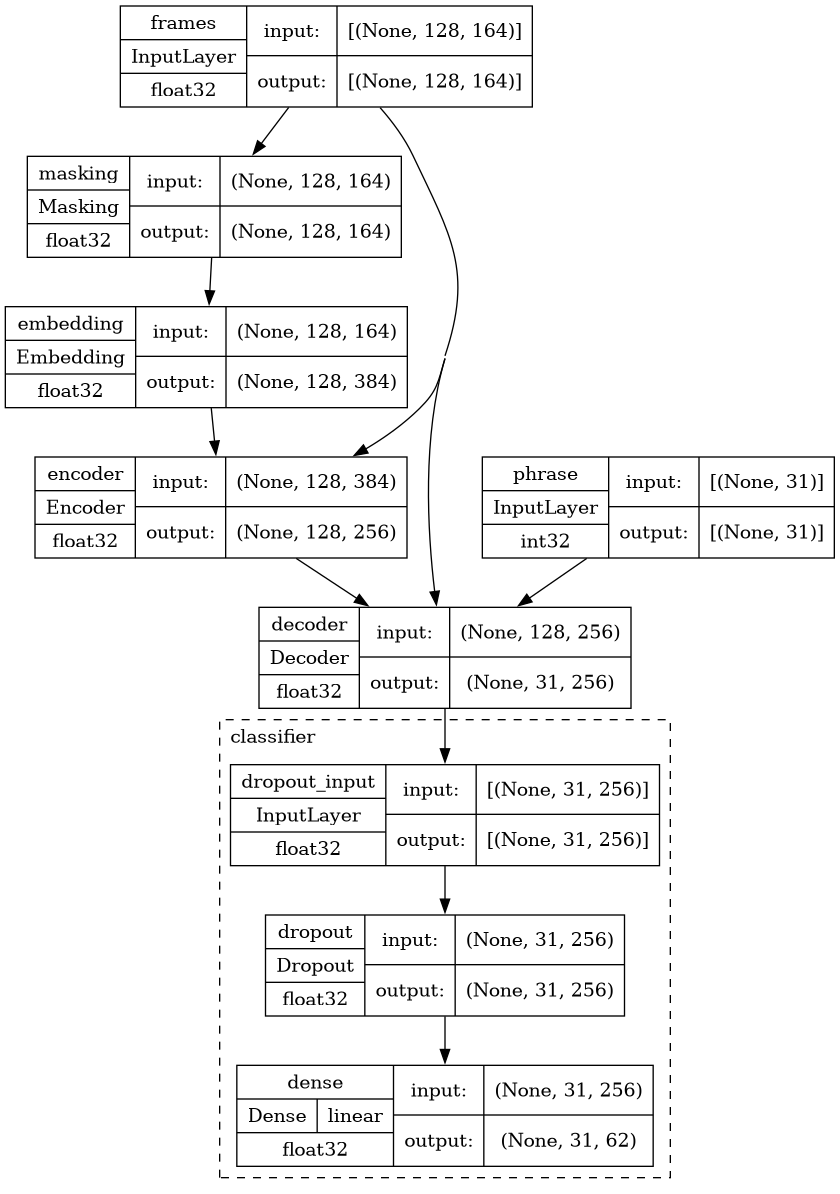

In [60]:
# Plot Model Architecture
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

# Verify Training Flag

In [61]:
def verify_correct_training_flag():
    # Verify static output for inference
    pred = model(X_batch_small, training=False)
    for _ in tqdm(range(10)):
        assert tf.reduce_min(tf.cast(pred == model(X_batch_small, training=False), tf.int8)) == 1

    # Verify at least 99% varying output due to dropout during training
    for _ in tqdm(range(10)):
        assert tf.reduce_mean(tf.cast(pred != model(X_batch_small, training=True), tf.float32)) > 0.99
        
verify_correct_training_flag()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

# Verify No NaN Predictions

114/114 [==============================] - 7s 43ms/step
# NaN Values In Predictions: 0


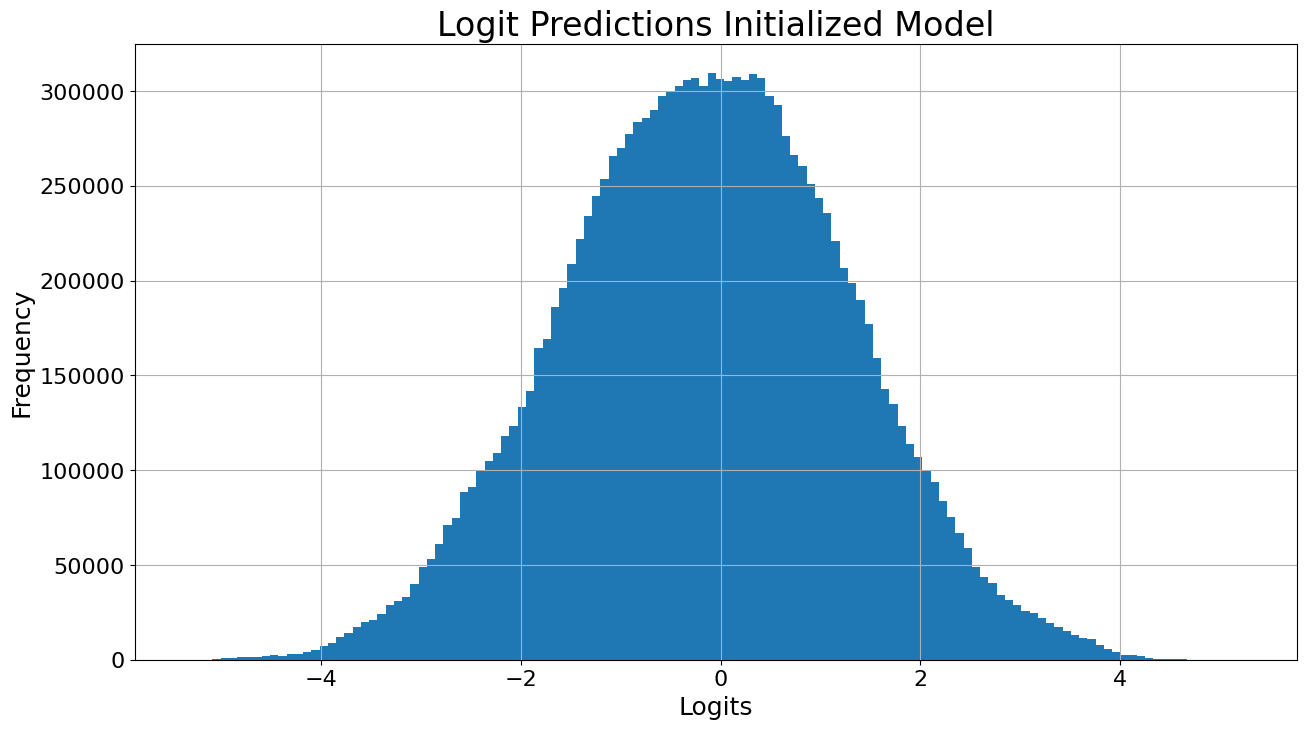

In [62]:
# Verify No NaN predictions
def verify_no_nan_predictions():
    y_pred = model.predict(
        val_dataset if USE_VAL else train_dataset,
        steps=N_VAL_STEPS_PER_EPOCH if USE_VAL else 100,
        verbose=VERBOSE,
    )

    print(f'# NaN Values In Predictions: {np.isnan(y_pred).sum()}')
    
    plt.figure(figsize=(15,8))
    plt.title(f'Logit Predictions Initialized Model')
    pd.Series(y_pred.flatten()).plot(kind='hist', bins=128)
    plt.xlabel('Logits')
    plt.grid()
    plt.show()
    
verify_no_nan_predictions()

# Learning Rate Scheduler

In [63]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

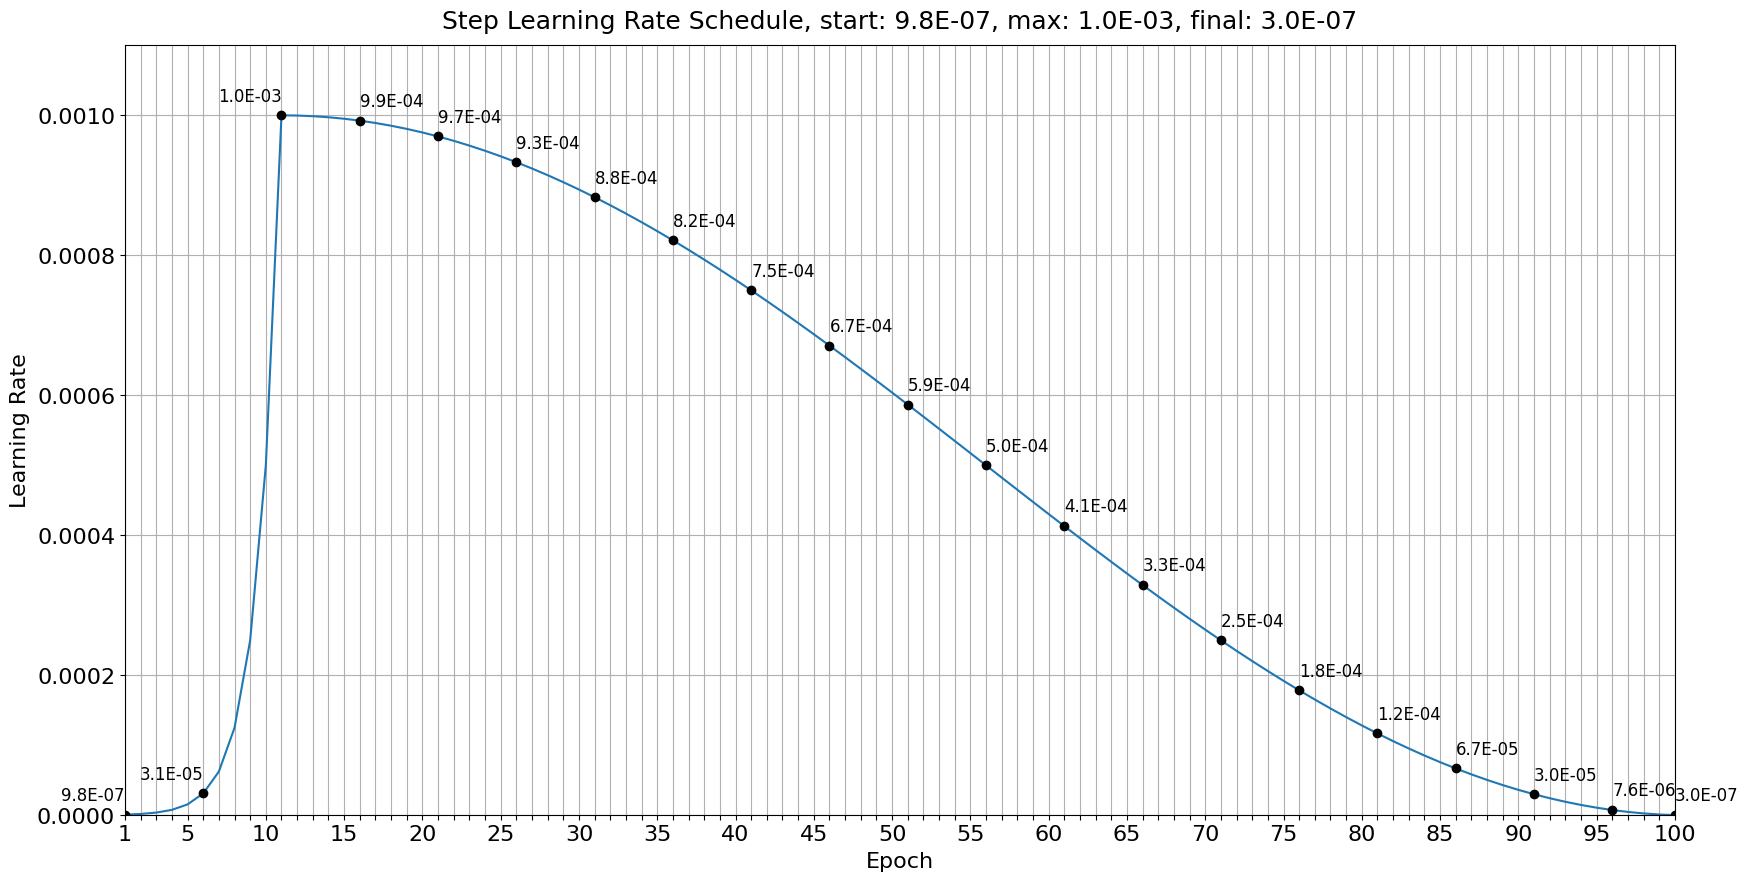

In [64]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    
    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])
    
    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=0)

# Weight Decay Callback

In [65]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

# Evaluate Initialized Model

In [66]:
# Evaluate Initialized Model On Validation Data
y_pred = model.evaluate(
    val_dataset if USE_VAL else train_dataset,
    steps=N_VAL_STEPS_PER_EPOCH if USE_VAL else TRAIN_STEPS_PER_EPOCH,
    verbose=VERBOSE,
)

114/114 [==============================] - 7s 44ms/step - loss: 4.9473 - top1acc: 0.0161 - top5acc: 0.0831


# Baseline

In [67]:
# baseline accuracy when only pad token is predicted
if USE_VAL:
    baseline_accuracy = np.mean(y_val == PAD_TOKEN)
else:
    baseline_accuracy = np.mean(y_train == PAD_TOKEN)
print(f'Baseline Accuracy: {baseline_accuracy:.4f}')

Baseline Accuracy: 0.3928


# Train

In [68]:
gc.collect()

39192

## log parameters during training

In [69]:
from tensorflow.keras.callbacks import Callback

class CustomNeptuneCallback(Callback):
    def __init__(self, run, num_epochs, batch_size, learning_rate, weight_decay_ratio, use_val_set, num_warmup_epochs):
        self.run = run
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.weight_decay_ratio = weight_decay_ratio
        self.use_val_set = use_val_set
        self.num_warmup_epochs= num_warmup_epochs
        self.logged_params = False

    def on_epoch_begin(self, epoch, logs=None):
        # Log parameters only once at the beginning of training
        if not self.logged_params:
            self.run["parameters/num_epochs"] = self.params['epochs']  # Total number of epochs
            self.run["parameters/batch_size"] = self.batch_size
            self.run["parameters/maximum_learning_rate"] = self.learning_rate
            self.run["parameters/weight_decay_ratio"] = self.weight_decay_ratio
            self.run["parameters/use_val_set"] = self.use_val_set
            self.run["parameters/num_warmup_epochs"] = self.num_warmup_epochs
            self.logged_params = True

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.run["training/epoch"].log(epoch)
        for key, value in logs.items():
            self.run[f"training/{key}"].log(value)


In [70]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/kaggle/working/Results:/',
                                                 save_best_only = True,
                                                 verbose=1)

## Train Model

In [71]:
if TRAIN_MODEL:
    # Clear all models in GPU
    tf.keras.backend.clear_session()

    # Get new fresh model
    model = get_model()

    # Sanity Check
    model.summary()

    # Actual Training
    history = model.fit(
            x=train_dataset,
            steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
            epochs=N_EPOCHS,
            # Only used for validation data since training data is a generator
            validation_data=val_dataset if USE_VAL else None,
            validation_steps=N_VAL_STEPS_PER_EPOCH if USE_VAL else None,
            callbacks=[
                lr_callback, #Learning rate 
                WeightDecayCallback(), #Weight decay
                cp_callback, # checkpoints
                CustomNeptuneCallback( #Log parameters in your Neptune project
                    run=run,
                    num_epochs=N_EPOCHS,
                    batch_size=BATCH_SIZE,
                    learning_rate=LR_MAX,
                    weight_decay_ratio=WD_RATIO,
                    use_val_set=USE_VAL,
                    num_warmup_epochs= N_WARMUP_EPOCHS
                )
            ],
            verbose=VERBOSE, #2
        )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 frames (InputLayer)         [(None, 128, 164)]           0         []                            
                                                                                                  
 masking (Masking)           (None, 128, 164)             0         ['frames[0][0]']              
                                                                                                  
 embedding (Embedding)       (None, 128, 384)             259968    ['masking[0][0]']             
                                                                                                  
 encoder (Encoder)           (None, 128, 256)             3643392   ['embedding[0][0]',           
                                                                     'frames[0][0]']          

In [72]:
# Save Model Weights
model.save_weights('ASL.h5')

In [73]:
# Log the saved model
run["artifacts/model"].upload('ASL.h5')

In [74]:
# Verify Model is Loaded Correctly
model.evaluate(
    val_dataset if USE_VAL else train_dataset,
    steps=N_VAL_STEPS_PER_EPOCH if USE_VAL else TRAIN_STEPS_PER_EPOCH,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
)

114/114 [==============================] - 5s 44ms/step - loss: 2.0665 - top1acc: 0.7787 - top5acc: 0.9215


[2.066514492034912, 0.7786694169044495, 0.9215453863143921]

# Levenshtein Distance

In [75]:
# Output Predictions to string
def outputs2phrase(outputs):
    if outputs.ndim == 2:
        outputs = np.argmax(outputs, axis=1)
    
    return ''.join([ORD2CHAR.get(s, '') for s in outputs])

In [76]:
@tf.function(jit_compile=True)
def predict_phrase(frames):
    # Add Batch Dimension
    frames = tf.expand_dims(frames, axis=0)
    # Start Phrase
    phrase = tf.fill([1,MAX_PHRASE_LENGTH], PAD_TOKEN)

    for idx in tf.range(MAX_PHRASE_LENGTH):
        # Cast phrase to int8
        phrase = tf.cast(phrase, tf.int8)
        # Predict Next Token
        outputs = model({
            'frames': frames,
            'phrase': phrase,
        })

        # Add predicted token to input phrase
        phrase = tf.cast(phrase, tf.int32)
        phrase = tf.where(
            tf.range(MAX_PHRASE_LENGTH) < idx + 1,
            tf.argmax(outputs, axis=2, output_type=tf.int32),
            phrase,
        )

    # Squeeze outputs
    outputs = tf.squeeze(phrase, axis=0)
    outputs = tf.one_hot(outputs, N_UNIQUE_CHARACTERS)

    # Return a dictionary with the output tensor
    return outputs

# Levenstein Distance Train

In [77]:
# Compute Levenstein Distances
def get_ld_train():
    N = 100 if IS_INTERACTIVE else 1000
    LD_TRAIN = []
    for idx, (frames, phrase_true) in enumerate(zip(tqdm(X_train, total=N), y_train)):
        # Predict Phrase and Convert to String
        phrase_pred = predict_phrase(frames).numpy()
        phrase_pred = outputs2phrase(phrase_pred)
        # True Phrase Ordinal to String
        phrase_true = outputs2phrase(phrase_true)
        # Add Levenstein Distance
        LD_TRAIN.append({
            'phrase_true': phrase_true,
            'phrase_true_len': len(phrase_true),
            'phrase_pred': phrase_pred,
            'levenshtein_distance': levenshtein(phrase_pred, phrase_true),
        })
        # Take subset in interactive mode
        if idx == N:
            break
            
    # Convert to DataFrame
    LD_TRAIN_DF = pd.DataFrame(LD_TRAIN)
    
    return LD_TRAIN_DF

In [78]:
LD_TRAIN_DF = get_ld_train()

# Display Errors
display(LD_TRAIN_DF.head(30))

  0%|          | 0/100 [00:00<?, ?it/s]

,phrase_true,phrase_true_len,phrase_pred,levenshtein_distance
0,3 creekhouse,12,3 creekhouse,0
1,hentaihubs.com,14,hentaihubs.comm,1
2,1383 william lanier,19,1383 william lanier,0
3,988 franklin lane,17,988 franklin lanee,1
4,6920 northeast 661st road,25,6920 northeast 661st road,0
5,www.freem.ne.jp,15,www.freem.me.jp,1
6,https://jsi.is/hukuoka,22,https://jsi.is/hkuoka,1
7,239613 stolze street,20,239613 stolze streett,1
8,242-197-6202,12,217-176-6602,5
9,271097 bayshore boulevard,25,271097 bayhore boulevard,1


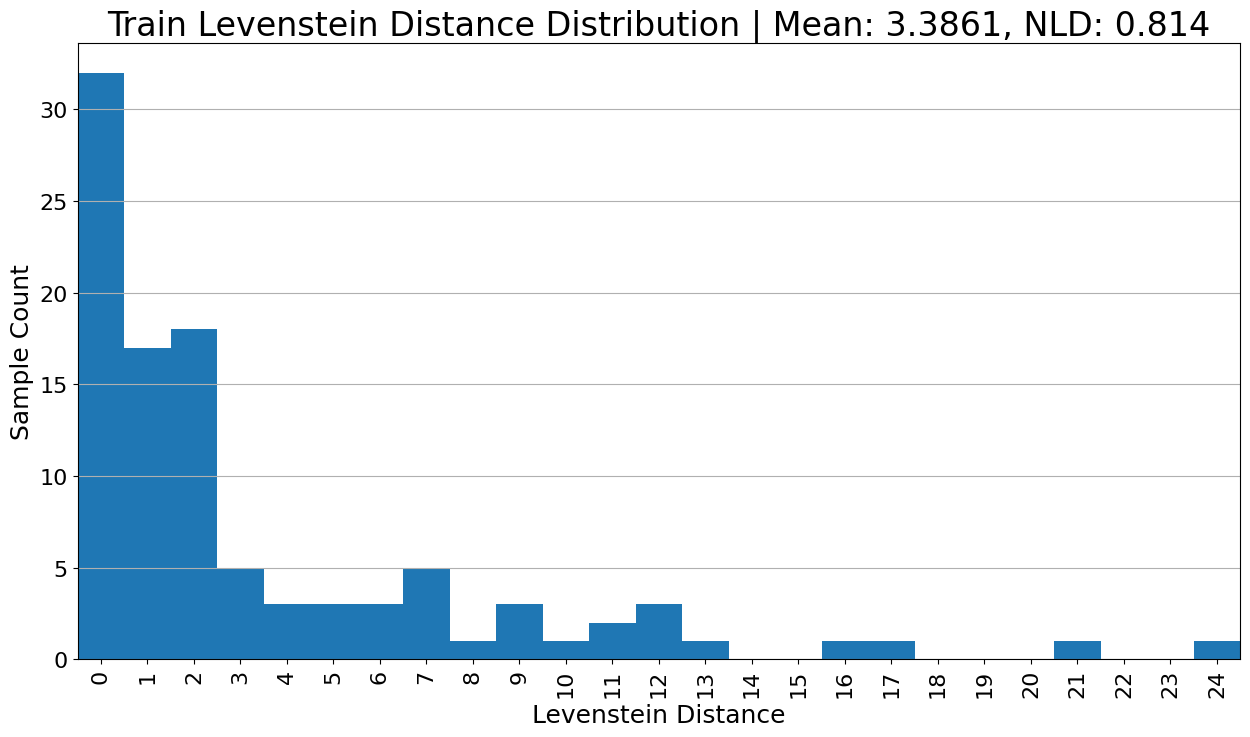

In [79]:
# Value Counts
LD_TRAIN_VC = dict([(i, 0) for i in range(LD_TRAIN_DF['levenshtein_distance'].max()+1)])
for ld in LD_TRAIN_DF['levenshtein_distance']:
    LD_TRAIN_VC[ld] += 1

# Evaluation Metric
N = LD_TRAIN_DF['phrase_true_len'].sum()
D = LD_TRAIN_DF['levenshtein_distance'].sum()
nld = (N - D) / N

LD_TRAIN_VC = dict([(i, 0) for i in range(LD_TRAIN_DF['levenshtein_distance'].max()+1)])
for ld in LD_TRAIN_DF['levenshtein_distance']:
    LD_TRAIN_VC[ld] += 1

plt.figure(figsize=(15,8))
pd.Series(LD_TRAIN_VC).plot(kind='bar', width=1)
plt.title(f'Train Levenstein Distance Distribution | Mean: {LD_TRAIN_DF.levenshtein_distance.mean():.4f}, NLD: {nld:.3f}')
plt.xlabel('Levenstein Distance')
plt.ylabel('Sample Count')
plt.xlim(-0.50, LD_TRAIN_DF.levenshtein_distance.max()+0.50)
plt.grid(axis='y')
plt.savefig('temp.png')
plt.show()

# BLEU and Rouge Evaluation Metrics

## Train dataset

In [ ]:
Phrase_true_list = []
Phrase_pred_list = []
for idx, (frames, phrase_true) in enumerate(zip(tqdm(X_train), y_train)):
        # Predict Phrase and Convert to String
        phrase_pred = predict_phrase(frames).numpy()
        phrase_pred = outputs2phrase(phrase_pred)
        Phrase_pred_list.append(phrase_pred)
        # True Phrase Ordinal to String
        phrase_true = outputs2phrase(phrase_true)
        Phrase_true_list.append(phrase_true)

In [352]:
Phrase_pred_train=[]
for Phrase in Phrase_true_list:
    Phrase_true_.append([Phrase])
    
Phrase_pred_train=[]
for Phrase in Phrase_pred_list:
    Phrase_pred_train.append([Phrase])

In [354]:
for ref, pred in zip(Phrase_true_, Phrase_pred_):
    # BLEU scores
    total_bleu_1 += sentence_bleu(ref, pred, weights=(1, 0, 0, 0))
    total_bleu_2 += sentence_bleu(ref, pred, weights=(0.5, 0.5, 0, 0))
    total_bleu_3 += sentence_bleu(ref, pred, weights=(0.33, 0.33, 0.33, 0))
    total_bleu_4 += sentence_bleu(ref, pred, weights=(0.25, 0.25, 0.25, 0.25))
    
    # ROUGE-L score
    rouge = Rouge()
    rouge_scores = rouge.get_scores(pred, ref)
    total_rouge_l += rouge_scores[0]['rouge-l']['f']


# Calculate the average of each metric
avg_bleu_1 = (total_bleu_1 / len(Phrase_true_list))*0.01
avg_bleu_2 = (total_bleu_2 / len(Phrase_true_list))*0.01
avg_bleu_3 = (total_bleu_3 / len(Phrase_true_list))*0.01
avg_bleu_4 = (total_bleu_4 / len(Phrase_true_list))*0.01
avg_rouge_l = (total_rouge_l / len(Phrase_true_list))*0.01

# Log the metrics
print(f"BLEU-1: {avg_bleu_1:.4f}, BLEU-2: {avg_bleu_2:.4f}, BLEU-3: {avg_bleu_3:.4f}, BLEU-4: {avg_bleu_4:.4f}")
print(f"METEOR: {avg_rouge_l:.4f}")

BLEU-1: 0.2319, BLEU-2: 0.2576, BLEU-3: 0.2704, BLEU-4: 0.2766
METEOR: 0.1215


## Validation set

In [ ]:
Phrase_true_list = []
Phrase_pred_list = []
for idx, (frames, phrase_true) in enumerate(zip(tqdm(X_val), y_val)):
        # Predict Phrase and Convert to String
        phrase_pred = predict_phrase(frames).numpy()
        phrase_pred = outputs2phrase(phrase_pred)
        Phrase_pred_list.append(phrase_pred)
        # True Phrase Ordinal to String
        phrase_true = outputs2phrase(phrase_true)
        Phrase_true_list.append(phrase_true)

In [356]:
Phrase_true_=[]
for Phrase in Phrase_true_list:
    Phrase_true_.append([Phrase])

In [357]:
Phrase_pred_=[]
for Phrase in Phrase_pred_list:
    Phrase_pred_.append([Phrase])

In [358]:
for ref, pred in zip(Phrase_true_, Phrase_pred_):
    # BLEU scores
    total_bleu_1 += sentence_bleu(ref, pred, weights=(1, 0, 0, 0))
    total_bleu_2 += sentence_bleu(ref, pred, weights=(0.5, 0.5, 0, 0))
    total_bleu_3 += sentence_bleu(ref, pred, weights=(0.33, 0.33, 0.33, 0))
    total_bleu_4 += sentence_bleu(ref, pred, weights=(0.25, 0.25, 0.25, 0.25))
    
    # ROUGE-L score
    rouge = Rouge()
    rouge_scores = rouge.get_scores(pred, ref)
    total_rouge_l += rouge_scores[0]['rouge-l']['f']


# Calculate the average of each metric
avg_bleu_1 = (total_bleu_1 / len(Phrase_true_list))*0.01
avg_bleu_2 = (total_bleu_2 / len(Phrase_true_list))*0.01
avg_bleu_3 = (total_bleu_3 / len(Phrase_true_list))*0.01
avg_bleu_4 = (total_bleu_4 / len(Phrase_true_list))*0.01
avg_rouge_l = (total_rouge_l / len(Phrase_true_list))*0.1

# Log the metrics
print(f"BLEU-1: {avg_bleu_1:.4f}, BLEU-2: {avg_bleu_2:.4f}, BLEU-3: {avg_bleu_3:.4f}, BLEU-4: {avg_bleu_4:.4f}")
print(f"METEOR: {avg_rouge_l:.4f}")

BLEU-1: 0.1241, BLEU-2: 0.1379, BLEU-3: 0.1447, BLEU-4: 0.1480
METEOR: 0.6840


# Levenstein Distance Evaluation

In [105]:
# Compute Levenstein Distances
def get_ld_val():
    N = 100 if IS_INTERACTIVE else 1000
    LD_VAL = []
    for idx, (frames, phrase_true) in enumerate(zip(tqdm(X_val, total=N), y_val)):
        # Predict Phrase and Convert to String
        phrase_pred = predict_phrase(frames).numpy()
        phrase_pred = outputs2phrase(phrase_pred)
        # True Phrase Ordinal to String
        phrase_true = outputs2phrase(phrase_true)
        # Add Levenstein Distance
        LD_VAL.append({
            'phrase_true': phrase_true,
            'phrase_true_len': len(phrase_true),
            'phrase_pred': phrase_pred,
            'levenshtein_distance': levenshtein(phrase_pred, phrase_true),
        })
        # Take subset in interactive mode
        if idx == N:
            break
            
    # Convert to DataFrame
    LD_VAL_DF = pd.DataFrame(LD_VAL)
    
    return LD_VAL_DF

In [106]:
if USE_VAL:
    LD_VAL_DF = get_ld_val()

    # Display Errors
    display(LD_VAL_DF.head(30))

  0%|          | 0/100 [00:00<?, ?it/s]

,phrase_true,phrase_true_len,phrase_pred,levenshtein_distance
0,scales/kuhaylah,15,scales/kuhaylaaa,2
1,+51-2721-208-63,15,+51-271-21-208-633,3
2,1600 fire water,15,1600 water water,4
3,620-510-6135,12,620-510-6135,0
4,69 alec roy south road,22,2260 corison road 2025,18
5,6738 co 5670,12,738/567000,7
6,201 galveston country club dr,29,201 glveston country,9
7,4821 holly ridge circle,23,4821 holly ridge circle,0
8,www.ipsah.edu.my,16,www.iahredu.my,3
9,1088 west aberdeen street,25,88 west aberdeen streett,3


Exception ignored in: <function tqdm.__del__ at 0x795180e46ef0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/tqdm/std.py", line 1149, in __del__
    self.close()
  File "/opt/conda/lib/python3.10/site-packages/tqdm/notebook.py", line 278, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


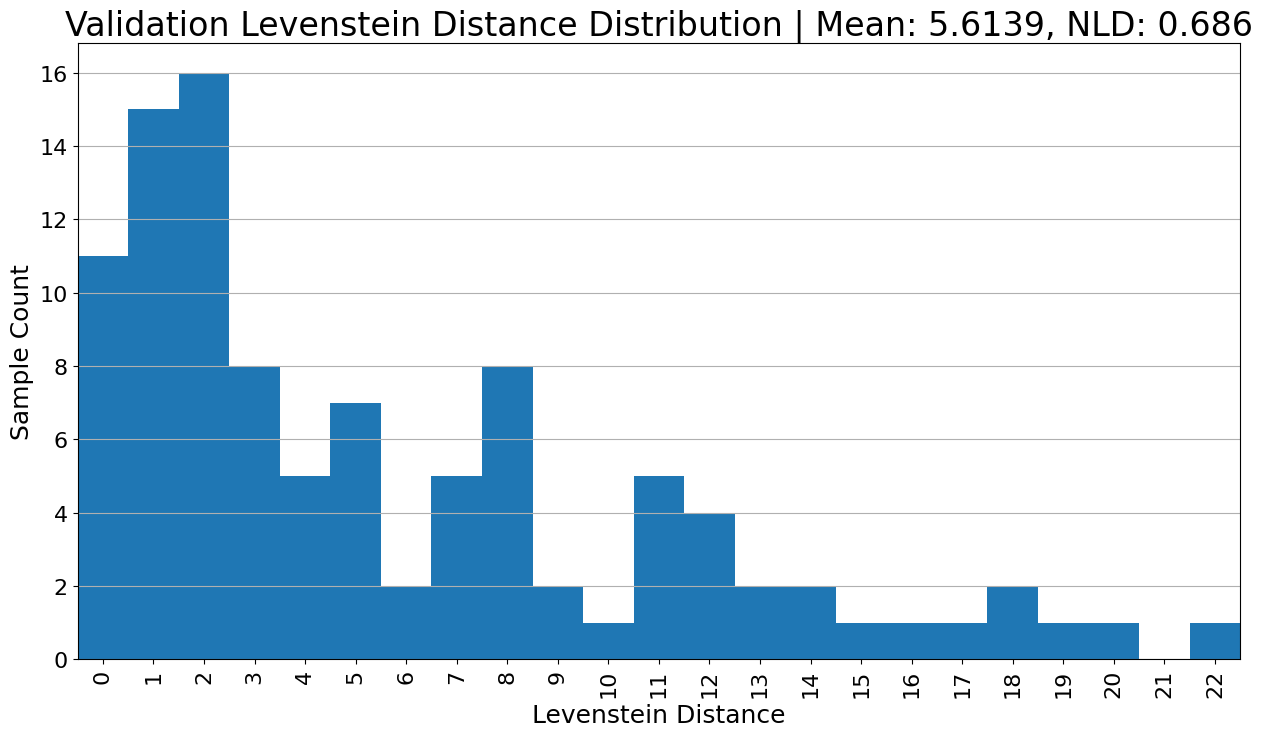

In [107]:
# Value Counts
if USE_VAL:
    # Evaluation Metric
    N = LD_VAL_DF['phrase_true_len'].sum()
    D = LD_VAL_DF['levenshtein_distance'].sum()
    nld = (N - D) / N
    
    LD_VAL_VC = dict([(i, 0) for i in range(LD_VAL_DF['levenshtein_distance'].max()+1)])
    for ld in LD_VAL_DF['levenshtein_distance']:
        LD_VAL_VC[ld] += 1

    plt.figure(figsize=(15,8))
    pd.Series(LD_VAL_VC).plot(kind='bar', width=1)
    plt.title(f'Validation Levenstein Distance Distribution | Mean: {LD_VAL_DF.levenshtein_distance.mean():.4f}, NLD: {nld:.3f}')
    plt.xlabel('Levenstein Distance')
    plt.ylabel('Sample Count')
    plt.xlim(-0.50, LD_VAL_DF.levenshtein_distance.max()+0.50)
    plt.grid(axis='y')
    plt.savefig('temp.png')
    plt.show()

# Training History

In [108]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    # Only plot when training
    if not TRAIN_MODEL:
        return
    
    plt.figure(figsize=(20, 10))
    
    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()

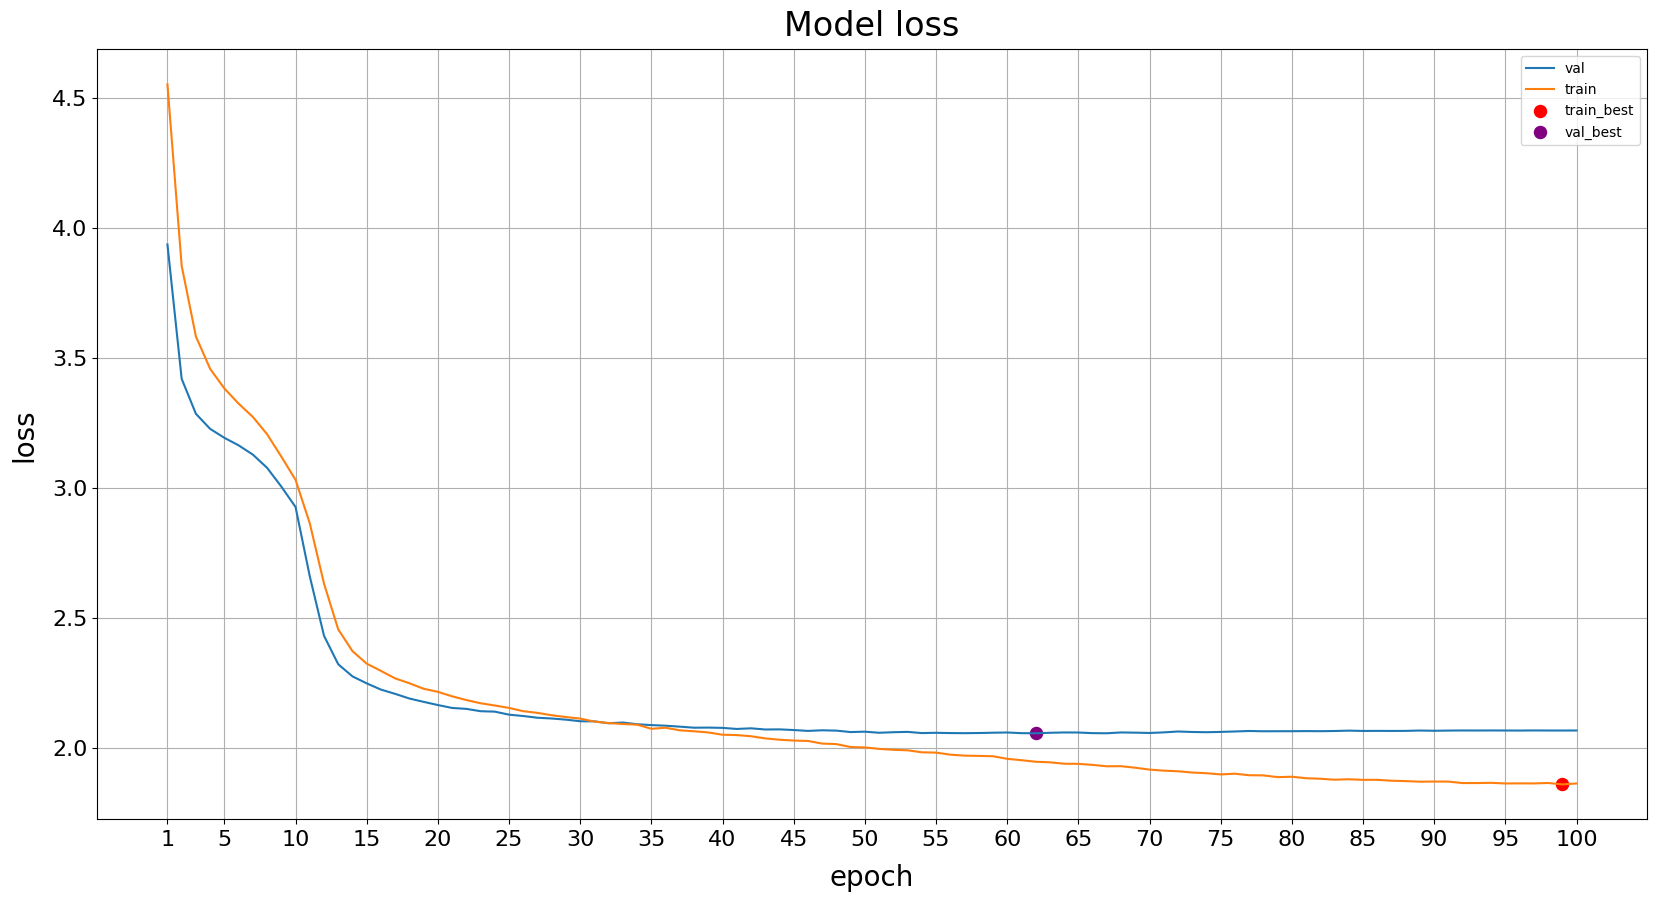

In [109]:
# training loss history
plot_history_metric('loss', f_best=np.argmin)

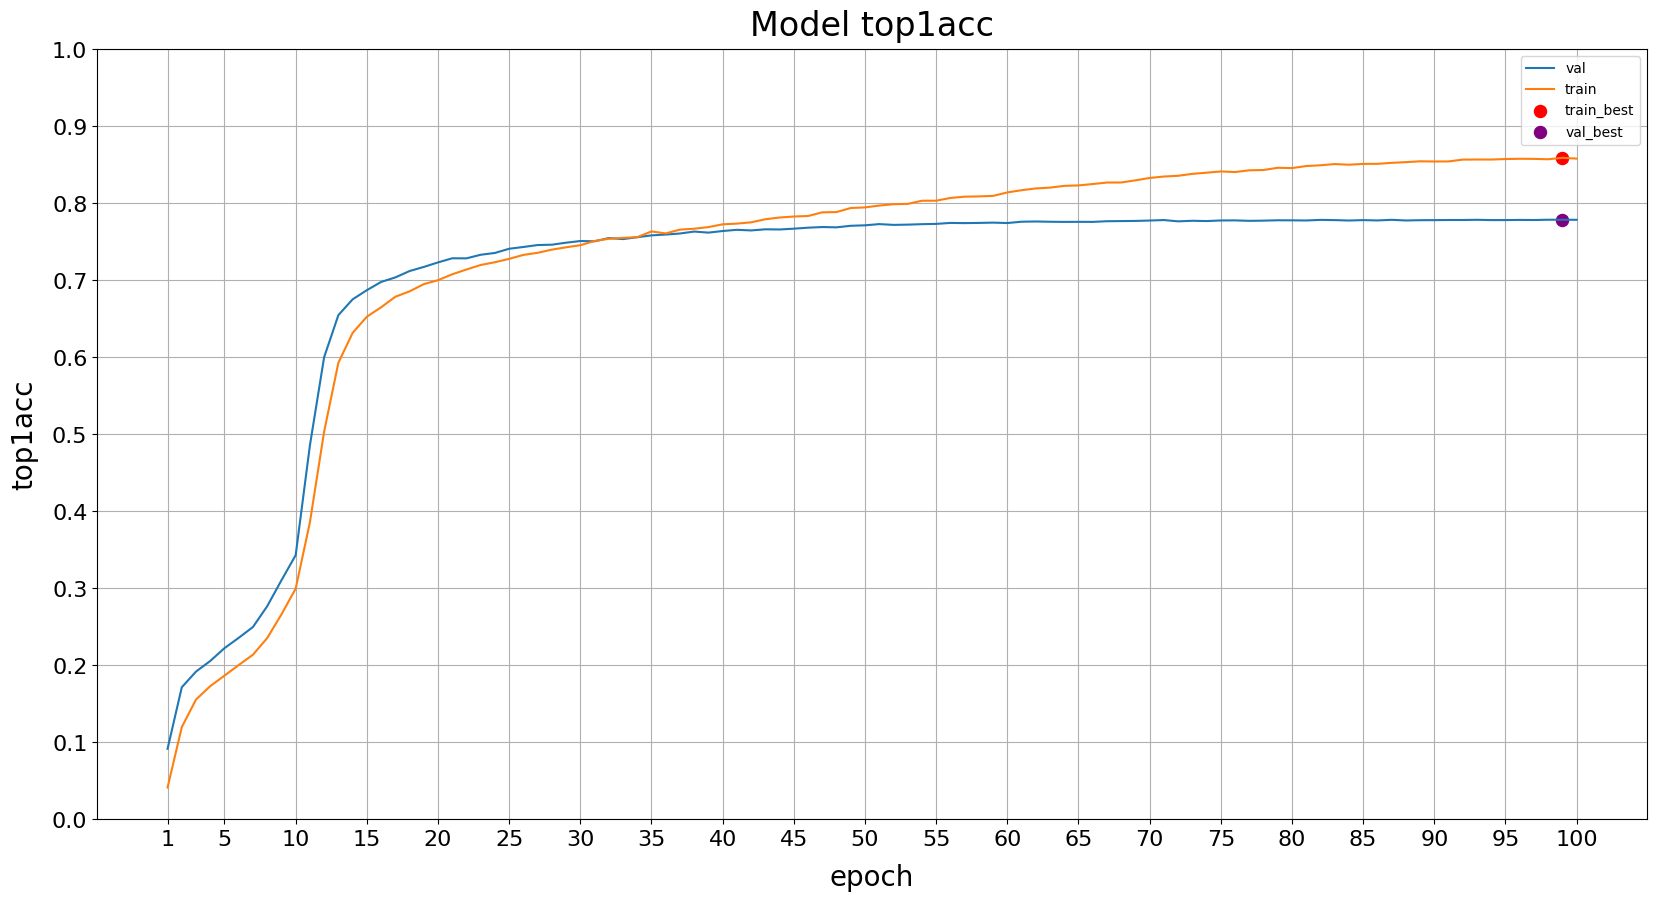

In [110]:
# Top1accuracy history during training
plot_history_metric('top1acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

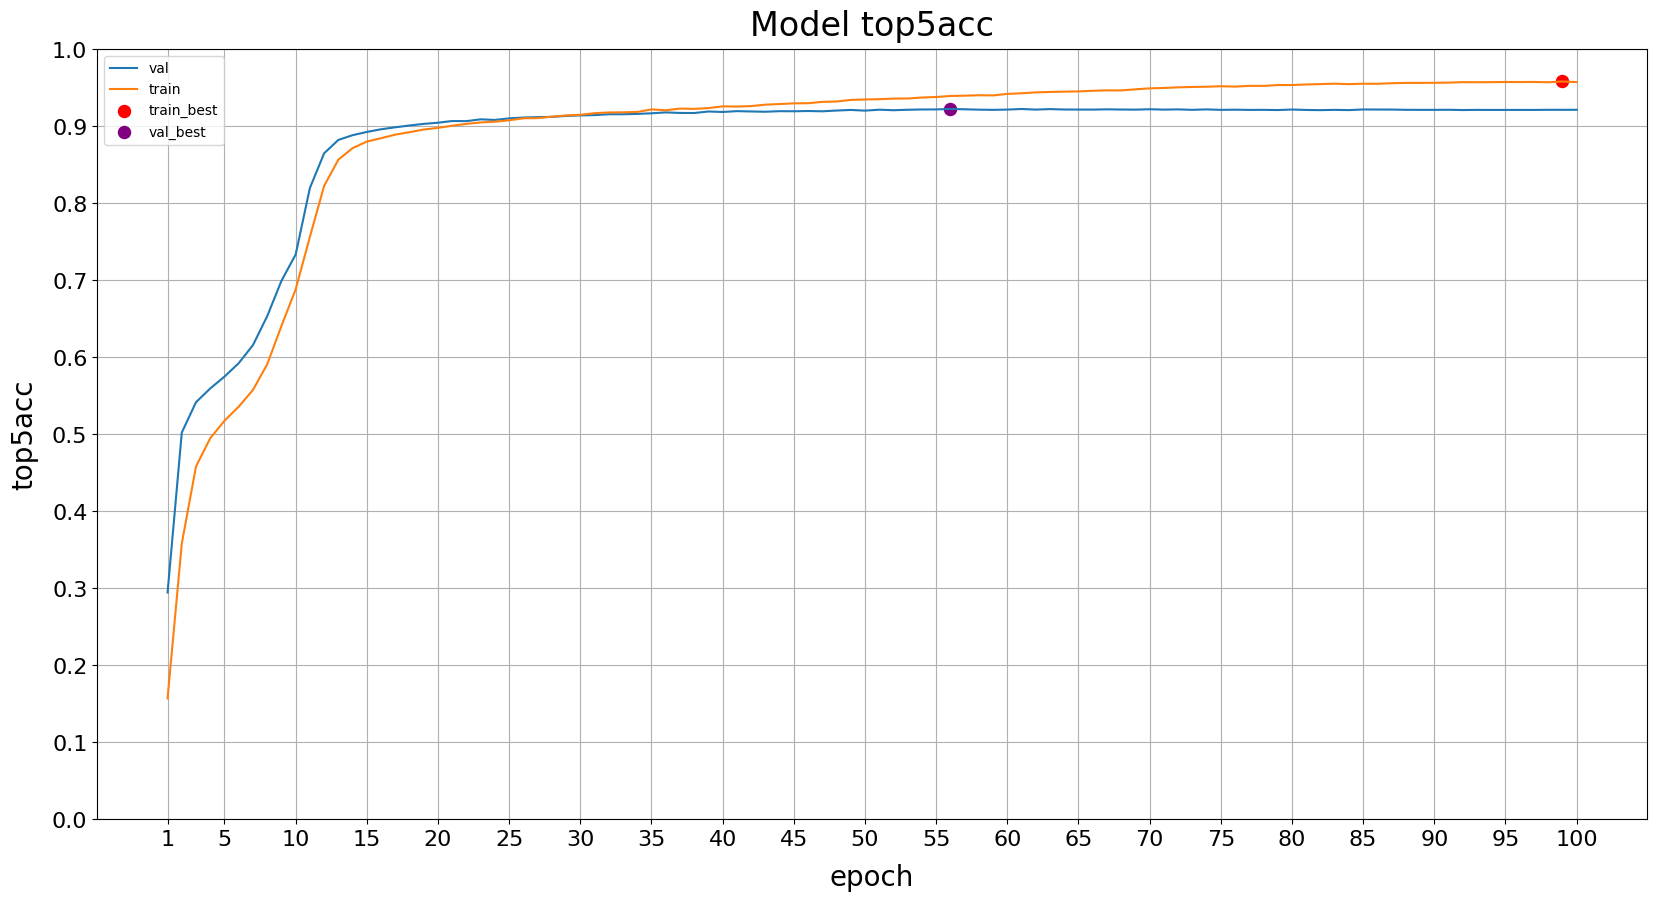

In [111]:
# Top5accuracy history during training
plot_history_metric('top5acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

# Inference

In [112]:
# Model Layer Names
for l in model.layers:
    print(l.name)

frames
masking
embedding
encoder
phrase
decoder
classifier


In [164]:
# TFLite model For model and inference saving
class TFLiteModel(tf.Module):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.preprocess_layer = preprocess_layer
        self.model = model
    
    @tf.function(jit_compile=True)
    def encoder(self, x, frames_inp):
        x = self.model.get_layer('embedding')(x)
        x = self.model.get_layer('encoder')(x, frames_inp)
        
        return x
        
    @tf.function(jit_compile=True)
    def decoder(self, x, phrase_inp, frames_inp):
        x = self.model.get_layer('decoder')(x, phrase_inp, frames_inp)
        x = self.model.get_layer('classifier')(x)
        
        return x
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, N_COLS0], dtype=tf.float32, name='inputs')])
    def __call__(self, inputs):
        # Number Of Input Frames
        N_INPUT_FRAMES = tf.shape(inputs)[0]
        # Preprocess Data
        frames_inp = self.preprocess_layer(inputs)        
        # Add Batch Dimension
        frames_inp = tf.expand_dims(frames_inp, axis=0)
        # Get Encoding
        encoding = self.encoder(frames_inp, frames_inp)
        # Make Prediction
        phrase = tf.fill([1,MAX_PHRASE_LENGTH], PAD_TOKEN)
        # Predict One Token At A Time
        stop = False
        for idx in tf.range(MAX_PHRASE_LENGTH):
            # Cast phrase to int8
            phrase = tf.cast(phrase, tf.int8)
            # If EOS token is predicted, stop predicting
            outputs = tf.cond(
                stop,
                lambda: tf.one_hot(tf.cast(phrase, tf.int32), N_UNIQUE_CHARACTERS),
                lambda: self.decoder(encoding, phrase, frames_inp)
            )
            # Add predicted token to input phrase
            phrase = tf.cast(phrase, tf.int32)
            # Replcae PAD token with predicted token up to idx
            phrase = tf.where(
                tf.range(MAX_PHRASE_LENGTH) < idx + 1,
                tf.argmax(outputs, axis=2, output_type=tf.int32),
                phrase,
            )
            # Predicted Token
            predicted_token = phrase[0,idx]
            # If EOS (End Of Sentence) token is predicted stop
            if not stop:
                stop = predicted_token == EOS_TOKEN
            
        # Squeeze outputs
        outputs = tf.squeeze(phrase, axis=0)
        outputs = tf.one_hot(outputs, N_UNIQUE_CHARACTERS)
            
        # Return a dictionary with the output tensor
        return {'outputs': outputs }

# Define TF Lite Model
tflite_keras_model = TFLiteModel(model)

# Sanity Check
demo_sequence_id = example_parquet_df.index.unique()[900]
demo_raw_data = example_parquet_df.loc[demo_sequence_id, COLUMNS0].values
demo_phrase_true = train_sequence_id.loc[demo_sequence_id, 'phrase']
print(f'demo_raw_data shape: {demo_raw_data.shape}, dtype: {demo_raw_data.dtype}')
demo_output = tflite_keras_model(demo_raw_data)['outputs'].numpy()
print(f'demo_output shape: {demo_output.shape}, dtype: {demo_output.dtype}')
print(f'demo_outputs phrase decoded: {outputs2phrase(demo_output)}')
print(f'phrase true: {demo_phrase_true}')

demo_raw_data shape: (136, 164), dtype: float32
demo_output shape: (31, 62), dtype: float32
demo_outputs phrase decoded: +7-1856-24376
phrase true: +7-1856-24376


In [165]:
# Create Model Converter
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
# Convert Model
tflite_model = keras_model_converter.convert()
# Write Model
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)

In [166]:
# Add selected_columns json to only select specific columns from input frames
with open('inference_args.json', 'w') as f:
     json.dump({ 'selected_columns': COLUMNS0.tolist() }, f)

In [167]:
# Zip Model
!zip submission.zip /kaggle/working/model.tflite /kaggle/working/inference_args.json

  adding: kaggle/working/model.tflite (deflated 9%)
  adding: kaggle/working/inference_args.json (deflated 83%)
